# <p style="text-align: center;"> Reconocimiento de caracteres manuscritos utilizando redes neuronales</p>
<p style="text-align: center;"> Mauricio Cano Galván</p>
<p style="text-align: center;"> 25 de octubre de 2023</p>


El objetivo de esta práctica es generar una herramienta capaz de asociar imágenes de letras manuscritas con el caracter que se representa en ellas. Se utilizará un algoritmo de aprendizaje supervisado basado en una red neuronal convolucional, la cual permitirá extraer características de las imágenes a través de la convolución de filtros (también llamados "kernels").



### 1. Algoritmo de clasificación

#### 1.1 - Inicialización

Para el entrenamiento y prueba del algoritmo se utilizó una base de datos de libre acceso, la cual está compuesta por 372 450 imágenes. Cada imagen tiene dimensiones de 28x28 pixeles y contiene una sola letra mayúscula manuscrita. Cada imagen está etiquetada con un número  del 0 al 26, correspondiente a una letra del alfabeto. Los datos se importaron en un dataframe a partir de un archivo .csv. Esta base de datos contiene la información en forma de vectores, por lo que posteriormente será necesario transformar los datos en matrices de 28x28 para poder visualizarlos como imágenes.

Para esta práctica se utilizaron las siguientes librerías de Python:
* Pandas
* Numpy
* Keras
* Cv2
* Matplotlib
* Time
* Sci-kit learn
* TensorSlow
* Scipy
* Random

Para poder traducir las etiquetas de las imágenes en letras se estableció el diccionario **word_dict**, mientras que para hacer la conversión inversa (de letras a números) se utilizará el diccionario **inv_dict**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
import cv2
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from numpy import load, random
import random
from scipy import ndimage
import time
import tensorflow as tf
from tensorflow import keras

datos = pd.read_csv("A_Z Handwritten Data.csv")
word_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X', 24:'Y',25:'Z'}
inv_dict = {v: k for k, v in word_dict.items()}

#### 2.1 - Preprocesamiento de datos


Se separan los datos de sus etiquetas, obteniendo una matriz con las imágenes (X) y un vector con las etiquetas de cada una (y). Posteriormente se separan las imágenes en entrenamiento y prueba. Se han separado el 20% de los datos como datos de prueba, los cuales no serán utilizados en el entrenameinto del modelo. Se tranforman los datos en imágenes de 28x28 px y se les añade una dimensión más, correspondiente al canal de color blanco y negro, obteniendo un conjunto de imágenes de 28x28x1. El vector de etiquetas se convirtió a categorías en formato *"One Hot Encoding"* para poder introducirlo en la red neuronal correctamente. Al final, se utilizaronn 74 490 imágenes de prueba y 297 960 imágenes de entrenamiento.



In [2]:
X = datos.drop('0', axis=1)
y = datos['0']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2)
train_X = np.reshape(train_X.values, (train_X.shape[0], 28,28))
test_X = np.reshape(test_X.values, (test_X.shape[0], 28,28))
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],train_X.shape[2],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2],1)
train_yOHE = to_categorical(train_y, num_classes = 26, dtype='int') #Vectores de etiquetas convertidos a categorías en forma de One Hot Encoding
test_yOHE = to_categorical(test_y, num_classes = 26, dtype='int')

Ejemplo de imagen perteneciente al conjunto de prueba:

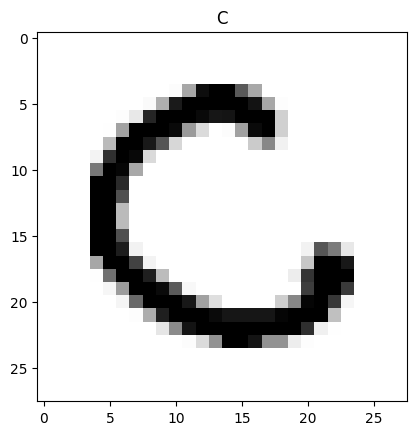

In [3]:


index = 60 #Número de imagen a visualizar
img1=np.reshape(test_X[index],(28,28))

plt.figure(1)
plt.imshow(img1, cmap='Greys', vmin=0, vmax=255)
plt.title(word_dict[test_y.iloc[index]])
plt.show()

#### 2.2 - Arquitectura de la red neuronal

Se utiliza una red neuronal convolucional compuesta principalmente por 2 etapas: identificación de características y clasificación. La primera etapa está compuesta por 3 capas de convolución 2D. Estas capas utilizan filtros de 3x3 pixeles para realizar las opreaciones de convolución. La salida de cada capa es reducida en dimesiones utilizando el método de Max pooling, el cual divide las imágenes de salida en zonas de 2x2 y mantiene únicamente el valor máximo de cada zona.

La etapa de clasificación está compuesta de dos capas de neuronas completamente conectadas y una capa final con la función de activación *"Softmax"* que permite clasificar los datos en una de las 26 categorías correspondientes a las letras del abecedario. En el resto de capas de la red se utilizó la función de activación *"ReLU"*. La función de pérdida del modelo es *"Categorical Cross-Enthropy"*, la cual será utilizada por el modelo para ajustar los pesos después de cada iteración y nos dará las métricas de pérdida.



In [4]:
model = Sequential()
#Fase de extracción de características
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1))) #Convolución con 32 filtros (inicialmente generados aleatoriamente) con tamaño de kernel de 3x3
model.add(MaxPool2D(pool_size=(2, 2), strides=2)) #Reducción de la dimensionalidad de las convoluciones para reducir el coste computacional y evitar overfititng
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
#Fase de clasificación
model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))
model.add(Dense(26,activation ="softmax"))
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

#### 2.3 - Entrenamiento y prueba de la red neuronal 

Se entrenó la red y se obtuvieron valores de exactitud y pérdida para los datos de entrenamiento y de prueba. El modelo se compiló utilizando los parámetros default de la librería (learning rate=0.001, batch size=32).

In [5]:
history = model.fit(train_X, train_yOHE, epochs=1, batch_size=32, validation_data = (test_X,test_yOHE), verbose=0)
print("Exactitud de prueba :", history.history['val_accuracy'])
print("Exactitud de entrenamiento :", history.history['accuracy'])
print("Pérdida de prueba :", history.history['val_loss'])
print("Pérdida de entrenamiento :", history.history['loss'])

Exactitud de prueba : [0.9757014513015747]
Exactitud de entrenamiento : [0.9576486945152283]
Pérdida de prueba : [0.08641170710325241]
Pérdida de entrenamiento : [0.152817040681839]


A continuación se muestran algunos ejemplos de clasificaciones que realizó la red.

1/1 [==============================] - 0s 133ms/step


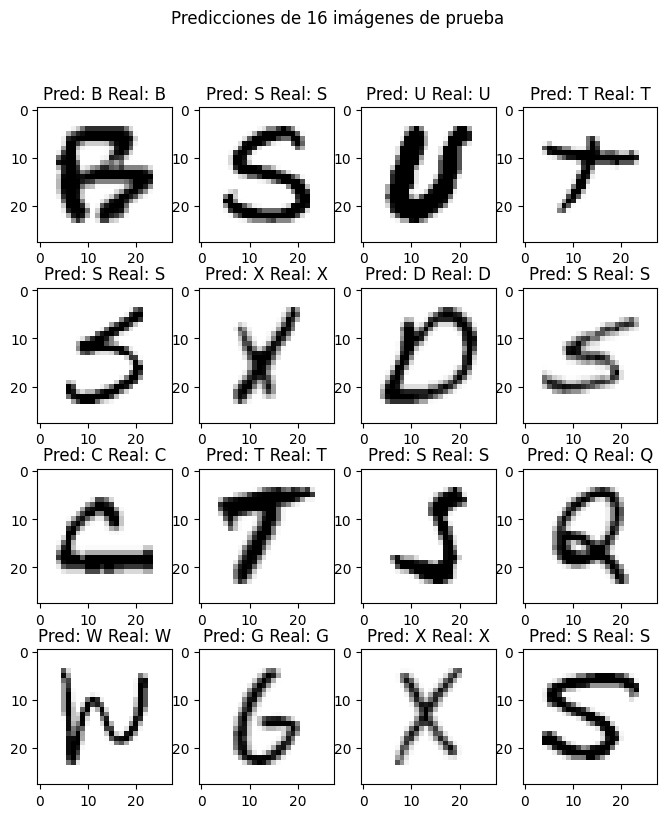

In [6]:
pred = model.predict(test_X[0:16])
fig, axes = plt.subplots(4,4, figsize=(8,9))
axes = axes.flatten()
fig.suptitle("Predicciones de "+str(axes.size)+" imágenes de prueba")
for i,ax in enumerate(axes): #Se enumeran los subplots y las imágenes predichas (no me gusta el comment tbh)
    img = np.reshape(test_X[i], (28,28)) #Se quita el canal de color blanco y negro
    ax.imshow(img, cmap="Greys")
    
    label = word_dict[np.argmax(pred[i])]
    correct = word_dict[np.argmax(test_yOHE[i])]
    ax.set_title("Pred: "+label+" Real: "+correct)


#### 2.4 - Pruebas con datos propios

Una vez entrenado el modelo se probó su rendimiento en imágenes propias. Estas imágenes contienen letras mayúsculas escritas a mano por diferentes personas. Cada letra se recortó individualmente y se preprocesó, normalizando su escala de color y reduciendo sus dimensiones a 28x28 px. Antes de reducir sus dimensiones, también se aplicó un desenfoque gaussiano a cada imagen para minimizar la pérdida de detalles al reducir su tamaño. Cada letra del abecedario cuenta con al menos 2 muestras en el conjunto de datos. Estas imágenes y sus etiquetas se guardaron en archivos de NumPy fácilmente importables. El recuento final de imágenes fue de **69**. A continuación se muestra la exactitud y pérdida del modelo al evaluar estos datos, así como el número de aciertos y errores por letra y algunos ejemplos de predicciones que realizó.

3/3 [==============================] - 0s 8ms/step
Exactitud : 0.7536231875419617
Pérdida : 0.8938262462615967


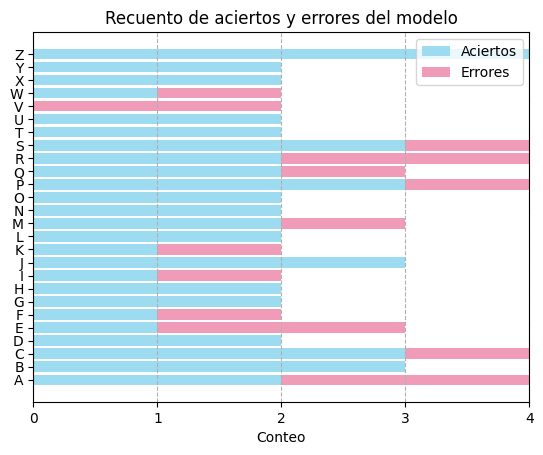

<Figure size 640x480 with 0 Axes>

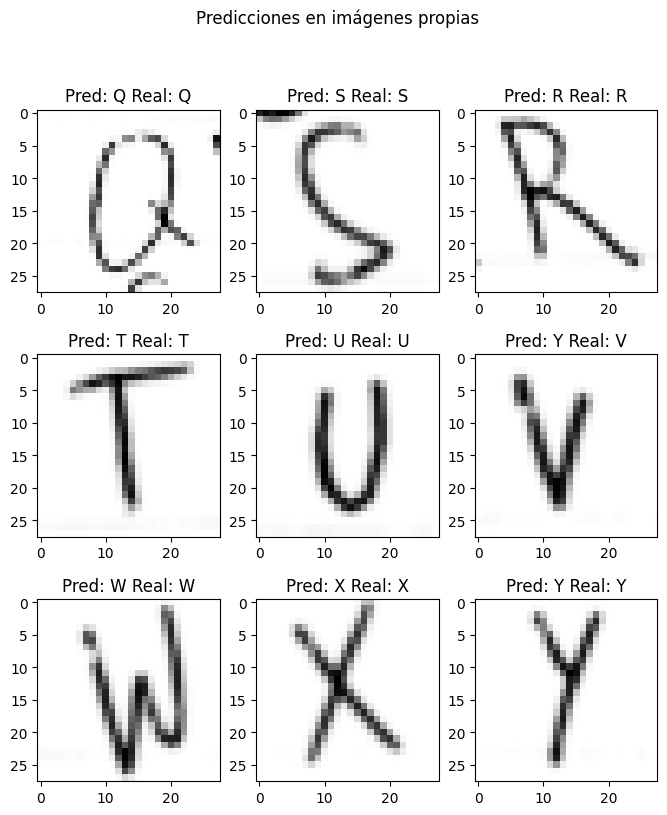

In [7]:

self_X=load('selfimgs.npy')
self_y=load('selflabels.npy')

self_y_inv=np.arange(len(self_y))
for i in self_y_inv:
    self_y_inv[i]=inv_dict[self_y[i]]

self_yOHE=to_categorical(self_y_inv, num_classes = 26, dtype='int')
pred2 = model.predict(self_X)
history_self=model.evaluate(self_X,self_yOHE, verbose=0)

print("Exactitud :", history_self[1])
print("Pérdida :", history_self[0])

pred_noOHE=[]
acc=np.zeros((len(pred2)))
for i in np.arange(len(acc)):
    label = word_dict[np.argmax(pred2[i])]
    correct = word_dict[np.argmax(self_yOHE[i])]
    if label == correct:
        acc[i]=1
    pred_noOHE=np.append(pred_noOHE,correct)
pred_matrix={"Letter": pred_noOHE, "Correct": acc}
pred_df = pd.DataFrame(pred_matrix)

alph=list(map(chr, range(65, 91)))
right=[]
wrong=[]
for i in alph:
    m = sum((pred_df.Letter == i) & (pred_df.Correct == 1))
    m_2 = sum((pred_df.Letter == i) & (pred_df.Correct == 0))
    right=np.append(right,m)
    wrong=np.append(wrong,m_2)
plt.figure(1)
plt.title('Recuento de aciertos y errores del modelo')
plt.xlabel('Conteo')
plt.barh(alph, right, color='#9cdbf0')
plt.barh(alph, wrong, left=right, color='#f09cb9')
plt.xticks(np.arange(5))
plt.grid(True, axis='x', linestyle='--',)
plt.legend(['Aciertos', 'Errores'], loc='upper right')
plt.show()


plt.figure(2)
fig, axes = plt.subplots(3,3, figsize=(8,9))
axes = axes.flatten()
fig.suptitle("Predicciones en imágenes propias")
for i,ax in enumerate(axes): #Se enumeran los subplots y las imágenes predichas (no me gusta el comment tbh)
    img = np.reshape(self_X[i], (28,28)) #Se quita el canal de color blanco y negro
    ax.imshow(img, cmap="Greys")
    label = word_dict[np.argmax(pred2[i])]
    correct = self_y[i]
    ax.set_title("Pred: "+label+" Real: "+correct)

### 3. Entrenamiento de red con datos propios

Se probó la misma arquitectura de red, esta vez entrenándola únicamente con las imágenes propias. Se utilizaron las 69 imágenes del conjunto con un train-test split del 20%, obteniendo 55 imágenes de entrenamiento y 14 de prueba.

1/1 [==============================] - 0s 88ms/step


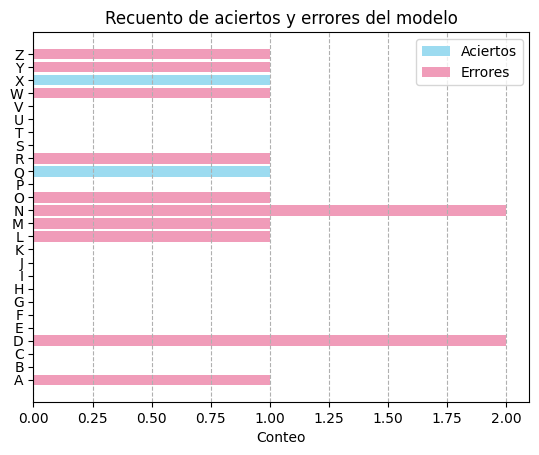

(0.0, 5.0)

<Figure size 640x480 with 0 Axes>

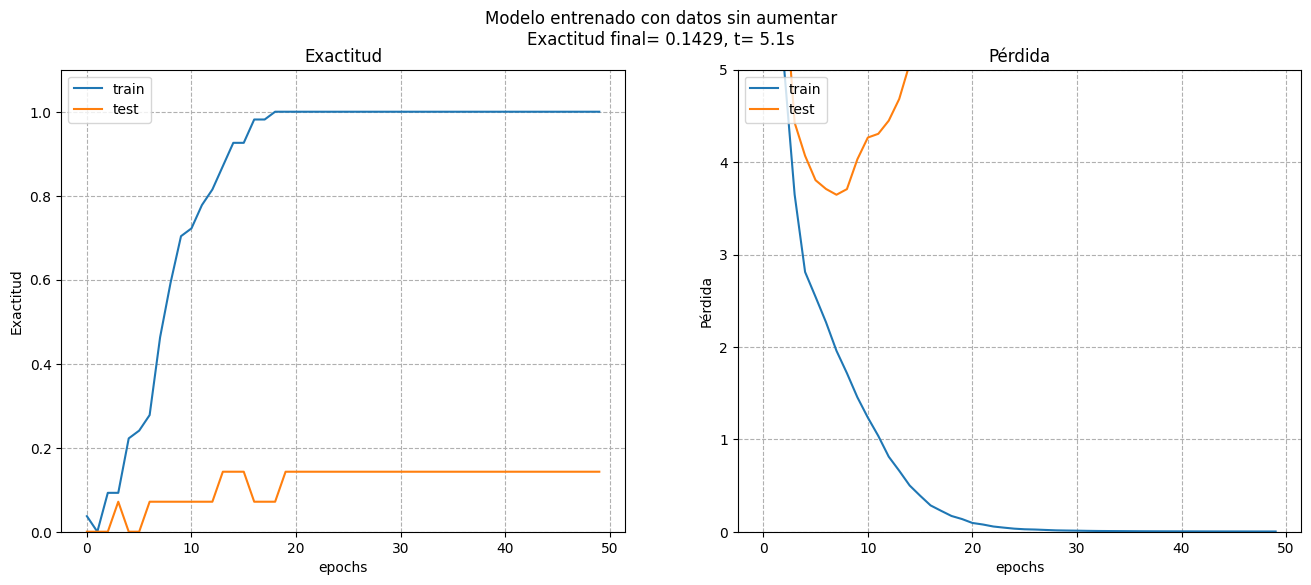

In [13]:
self_X=load('selfimgs.npy')
self_y=load('selflabels.npy')

og_X=self_X[0:68]
og_y=self_y[0:68]

og_y_inv=np.arange(len(og_y))
for i in og_y_inv:
    og_y_inv[i]=inv_dict[og_y[i]]

train_x3, test_x3, train_y3, test_y3 = train_test_split(og_X, og_y_inv, test_size = 0.2)

train_y3OHE = to_categorical(train_y3, num_classes = 26, dtype='int') #Vectores de etiquetas convertidos a categorías en forma de One Hot Encoding
test_y3OHE = to_categorical(test_y3, num_classes = 26, dtype='int')

start_time = time.time()

model_og = Sequential()
model_og.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1))) #Convolución con 32 filtros (inicialmente generados aleatoriamente) con tamaño de kernel de 3x3
model_og.add(MaxPool2D(pool_size=(2, 2), strides=2)) #Reducción de la dimensionalidad de las convoluciones para reducir el coste computacional y evitar overfititng
model_og.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model_og.add(MaxPool2D(pool_size=(2, 2), strides=2))
model_og.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model_og.add(MaxPool2D(pool_size=(2, 2), strides=2))
model_og.add(Flatten())
#Classification
model_og.add(Dense(64,activation ="relu"))
model_og.add(Dense(128,activation ="relu"))
model_og.add(Dense(26,activation ="softmax"))
model_og.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_og = model_og.fit(train_x3, train_y3OHE, epochs=50, batch_size=32, validation_data = (test_x3,test_y3OHE), verbose=0) #Batch size default=32

t= time.time()-start_time

pred_og = model_og.predict(test_x3)
pred_noOHE=[]
acc=np.zeros((len(pred_og)))
for i in np.arange(len(acc)):
    label = word_dict[np.argmax(pred_og[i])]
    correct = word_dict[np.argmax(test_y3OHE[i])]
    if label == correct:
        acc[i]=1
    pred_noOHE=np.append(pred_noOHE,correct)
pred_matrix={"Letter": pred_noOHE, "Correct": acc}
pred_df = pd.DataFrame(pred_matrix)

alph=list(map(chr, range(65, 91)))
right=[]
wrong=[]
for i in alph:
    m = sum((pred_df.Letter == i) & (pred_df.Correct == 1))
    m_2 = sum((pred_df.Letter == i) & (pred_df.Correct == 0))
    right=np.append(right,m)
    wrong=np.append(wrong,m_2)
plt.figure(1)
plt.title('Recuento de aciertos y errores del modelo')
plt.xlabel('Conteo')
plt.barh(alph, right, color='#9cdbf0')
plt.barh(alph, wrong, left=right, color='#f09cb9')
plt.grid(True, axis='x', linestyle='--',)
plt.legend(['Aciertos', 'Errores'], loc='upper right')
plt.show()

plt.figure(2)
fig, axes = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Modelo entrenado con datos sin aumentar\nExactitud final= "+str(np.around(history_og.history['val_accuracy'][len(history_og.history['val_accuracy'])-1], decimals=4))+", t= "+str(np.around(t, decimals=2))+"s")

axes[0].plot(history_og.history['accuracy'])
axes[0].plot(history_og.history['val_accuracy'])
axes[0].set_title('Exactitud')
axes[0].set_ylabel('Exactitud')
axes[0].set_xlabel('epochs')
axes[0].legend(['train', 'test'], loc='upper left')
axes[0].grid(True, linestyle='--',)
axes[0].set_ylim([0,1.1])

axes[1].plot(history_og.history['loss'])
axes[1].plot(history_og.history['val_loss'])
axes[1].set_title('Pérdida')
axes[1].set_ylabel('Pérdida')
axes[1].set_xlabel('epochs')
axes[1].legend(['train', 'test'], loc='upper left')
axes[1].grid(True, linestyle='--',)
axes[1].set_ylim([0,5])


#### 3.1 - Data Augmentation

Se observa que el rendimiento del modelo es pobre en datos de prueba. Esto puede ser debido a la baja cantidad de datos de entrenamiento con los que cuenta la red. Por esto, se propuso utilizar técnicas de Data Augmentation para multiplicar el número de datos de entrenamiento a partir de las imágenes originales. Se utilizaron 3 métodos diferentes: escalamiento, rotación e inversión de color.

* Escalamiento: Las dimensiones de las imágenes se modificaron de manera aleatoria en un rango de ±8 pixeles en cada eje. Esto significa a que la imágen más pequeña posible fue de 20x20 px y la más grande de 36x36 px. Se omitieron cambios entre -3 y 3 pixeles para que el cambio en tamaño fuera suficientemente significativo. Posteriormente, todas las imágenes fueron recortadas para regresar a dimensiones de 28x28 pixeles. Para poder hacer esto se añadió un padding alrededor de todas las imágenes, de modo que aunque una imagen haya sido reducida en tamaño, esta tenga suficientes datos para poder ser recortada. En esta etapa se aumentó el número de imágenes de 69 a 138.

* Rotación: Las imágenes obtuvidas en la etapa anterior se rotaron dos veces, primero en un ángulo de 15º y posteriormente de -15º. En esta etapa se inició con 138 imágenes y se terminó con 414

* Inversión de color: Todas las imágenes anteriores se invirtieron de color, **terminando con 828 imágenes distintas**.

En total, el proceso de data augmentation incrementó el número de imágenes en 1200%.

In [9]:

aug_X=self_X
lst=np.arange(8)+26#imgs en ese rango tienen fondo negro
lst2=np.arange(8)+69+26
lst=np.append(lst,lst2)
vec=np.arange(len(aug_X))
scale=[-8, -7, -6, -5, -4, 4, 5, 6, 7, 8]
for i in  vec:
    pic=aug_X[i]
    aug_dim=random.choice(scale) #Las imágenes cambiarán en dimensiones en el rango de +- 5 pixeles
    pic=cv2.resize(pic,(28+aug_dim,28+aug_dim))

    if i in lst:    #Imágenes con fondo negro que necesitan padding negro
        picpadded=np.pad(pic,5, 'constant', constant_values=(255, 255))
    else:
        picpadded=np.pad(pic,5) #Padding para cuando las imágenes se reducen de tamaño
    newsize=(len(picpadded))
    newmax=int(np.round(newsize/2+14))
    newmin=int(np.round(newsize/2-14))
    picfin=picpadded[newmin:newmax,newmin:newmax]
    picfin =np.expand_dims(picfin, axis=0)
    picfin =np.expand_dims(picfin, axis=3)
    aug_X = np.concatenate((aug_X,picfin), axis=0)

leng=len(aug_X)

vec=np.arange(leng)
for i in  vec:
    pic=aug_X[i]
    pic=np.reshape(pic,(28,28))
    if i in lst:    
        pic=np.pad(pic,10, 'constant', constant_values=(255, 255))
    pic_pos= ndimage.rotate(pic, 15)
    newsize=(len(pic_pos))
    newmax=int(np.round(newsize/2+14))
    newmin=int(np.round(newsize/2-14))
    pic_pos=pic_pos[newmin:newmax,newmin:newmax]
    pic_pos =np.expand_dims(pic_pos, axis=0)
    pic_pos =np.expand_dims(pic_pos, axis=3)
    aug_X = np.concatenate((aug_X,pic_pos), axis=0)


vec=np.arange(leng)
for i in  vec:
    pic=aug_X[i]
    pic=np.reshape(pic,(28,28))
    if i in lst:    
        pic=np.pad(pic,5, 'constant', constant_values=(255, 255))
    pic_neg= ndimage.rotate(pic, -15)
    newsize=(len(pic_neg))
    newmax=int(np.round(newsize/2+14))
    newmin=int(np.round(newsize/2-14))
    pic_neg=pic_neg[newmin:newmax,newmin:newmax]
    pic_neg =np.expand_dims(pic_neg, axis=0)
    pic_neg =np.expand_dims(pic_neg, axis=3)
    aug_X = np.concatenate((aug_X,pic_neg), axis=0)

vec=np.arange(len(aug_X))
for i in  vec:
    pic=aug_X[i]
    pic=255-pic
    pic =np.expand_dims(pic, axis=0)
    aug_X = np.concatenate((aug_X,pic), axis=0)

aug_y=np.concatenate((self_y,self_y,self_y,self_y,self_y,self_y,self_y,self_y,self_y,self_y,self_y,self_y),axis=0) #Actualizar el vector de variables


A continuación se pueden visualizar todas las tranformaciones realizadas en una letra a través del proceso de Data Augmentation.

Text(0.5, 1.0, 'Escalada y rotada -15º')

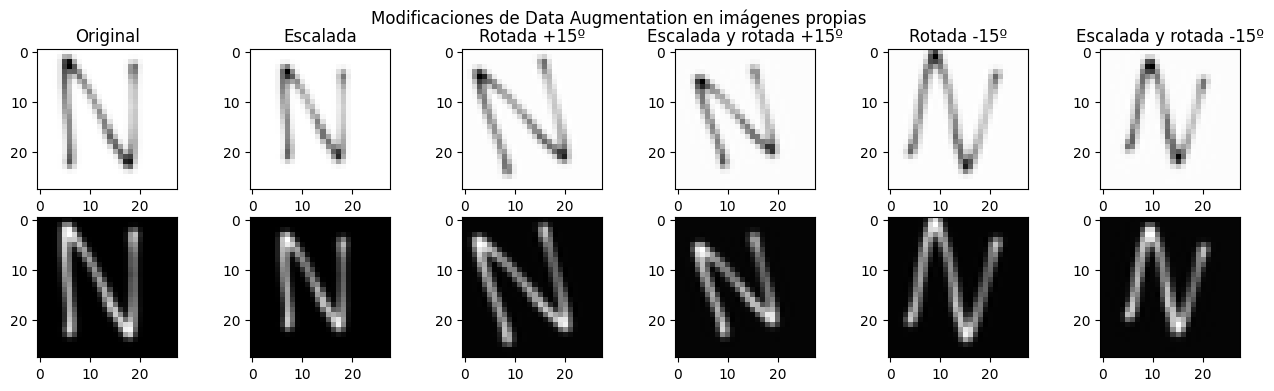

In [10]:
fig, axes = plt.subplots(2,6, figsize=(16,4))
axes = axes.flatten()
fig.suptitle("Modificaciones de Data Augmentation en imágenes propias")
index=47 #Letra del conjuto original de datos, valor entre 0 y 68
for i,ax in enumerate(axes): #Se enumeran los subplots y las imágenes predichas (no me gusta el comment tbh)
    i=i*len(self_X)
    img = np.reshape(aug_X[i+index], (28,28)) #Se quita el canal de color blanco y negro
    ax.imshow(img, cmap="Greys")
axtitle=axes[0]
axtitle.set_title("Original")
axtitle=axes[1]
axtitle.set_title("Escalada")
axtitle=axes[2]
axtitle.set_title("Rotada +15º")
axtitle=axes[3]
axtitle.set_title("Escalada y rotada +15º")
axtitle=axes[4]
axtitle.set_title("Rotada -15º")
axtitle=axes[5]
axtitle.set_title("Escalada y rotada -15º")

#### 3.2 - Entrenamiento y prueba de la red
Se separaron los datos en prueba y entrenamiento con un train-test split de 20%, obteniendo 662 imágenes de entrenamiento y 166 imágenes de prueba.

In [11]:
aug_y_inv=np.arange(len(aug_y))
for i in aug_y_inv:
    aug_y_inv[i]=inv_dict[aug_y[i]]

train_x2, test_x2, train_y2, test_y2 = train_test_split(aug_X, aug_y_inv, test_size = 0.2)

train_y2OHE = to_categorical(train_y2, num_classes = 26, dtype='int') #Vectores de etiquetas convertidos a categorías en forma de One Hot Encoding
test_y2OHE = to_categorical(test_y2, num_classes = 26, dtype='int')

Se entrenó un modelo con la misma arquitectura a la utilizada en la sección 3, utilizando el conjunto de imágenes aumentadas. Se observa una mejora significativa en el rendminiento del modelo (exactitud de 0.9398) en comparación con el entrenado con los datos sin aumentar.

In [ ]:
start_time = time.time()

model_aug = Sequential()
model_aug.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1))) #Convolución con 32 filtros (inicialmente generados aleatoriamente) con tamaño de kernel de 3x3
model_aug.add(MaxPool2D(pool_size=(2, 2), strides=2)) #Reducción de la dimensionalidad de las convoluciones para reducir el coste computacional y evitar overfititng
model_aug.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model_aug.add(MaxPool2D(pool_size=(2, 2), strides=2))
model_aug.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model_aug.add(MaxPool2D(pool_size=(2, 2), strides=2))
model_aug.add(Flatten())
#Classification
model_aug.add(Dense(64,activation ="relu"))
model_aug.add(Dense(128,activation ="relu"))
model_aug.add(Dense(26,activation ="softmax"))
model_aug.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_aug = model_aug.fit(train_x2, train_y2OHE, epochs=50, batch_size=32, validation_data = (test_x2,test_y2OHE), verbose=0) #Batch size default=32

t= time.time()-start_time

6/6 [==============================] - 0s 5ms/step


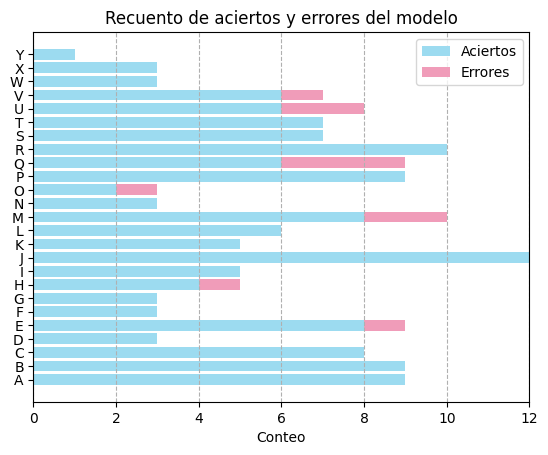

(0.0, 5.0)

<Figure size 640x480 with 0 Axes>

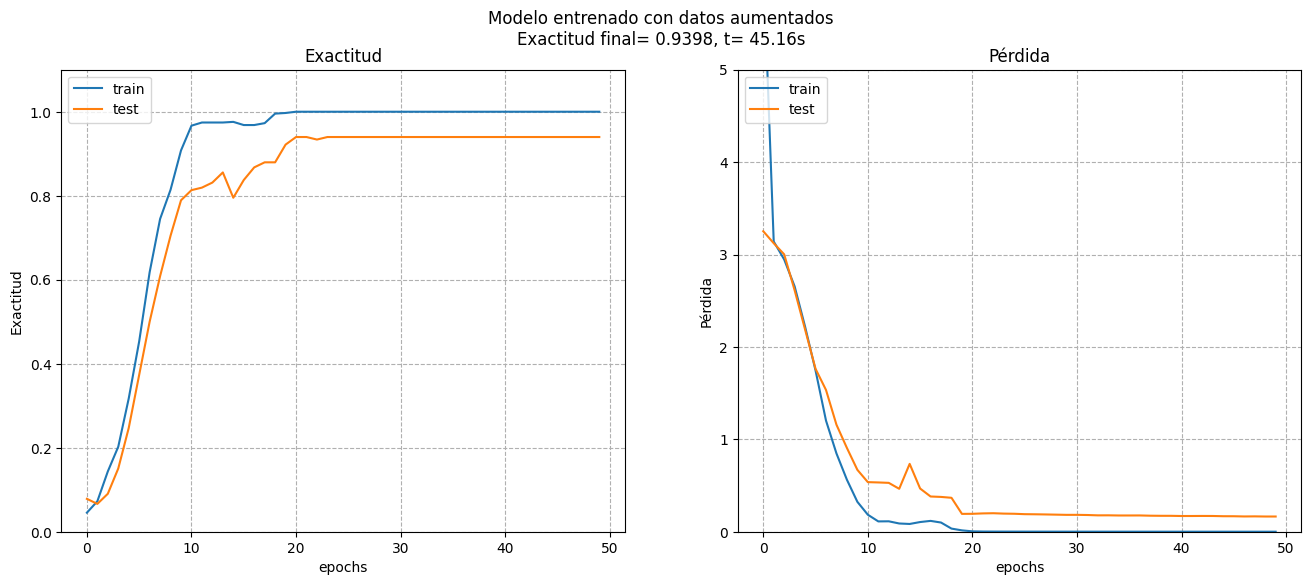

In [ ]:
pred_aug = model_aug.predict(test_x2)
pred_noOHE=[]
acc=np.zeros((len(pred_aug)))
for i in np.arange(len(acc)):
    label = word_dict[np.argmax(pred_aug[i])]
    correct = word_dict[np.argmax(test_y2OHE[i])]
    if label == correct:
        acc[i]=1
    pred_noOHE=np.append(pred_noOHE,correct)
pred_matrix={"Letter": pred_noOHE, "Correct": acc}
pred_df = pd.DataFrame(pred_matrix)

alph=list(map(chr, range(65, 91)))
right=[]
wrong=[]
for i in alph:
    m = sum((pred_df.Letter == i) & (pred_df.Correct == 1))
    m_2 = sum((pred_df.Letter == i) & (pred_df.Correct == 0))
    right=np.append(right,m)
    wrong=np.append(wrong,m_2)
plt.figure(1)
plt.title('Recuento de aciertos y errores del modelo')
plt.xlabel('Conteo')
plt.barh(alph, right, color='#9cdbf0')
plt.barh(alph, wrong, left=right, color='#f09cb9')
plt.grid(True, axis='x', linestyle='--',)
plt.legend(['Aciertos', 'Errores'], loc='upper right')
plt.show()



plt.figure(2)
fig, axes = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Modelo entrenado con datos aumentados\nExactitud final= "+str(np.around(history_aug.history['val_accuracy'][len(history_aug.history['val_accuracy'])-1], decimals=4))+", t= "+str(np.around(t, decimals=2))+"s")

axes[0].plot(history_aug.history['accuracy'])
axes[0].plot(history_aug.history['val_accuracy'])
axes[0].set_title('Exactitud')
axes[0].set_ylabel('Exactitud')
axes[0].set_xlabel('epochs')
axes[0].legend(['train', 'test'], loc='upper left')
axes[0].grid(True, linestyle='--',)
axes[0].set_ylim([0,1.1])

axes[1].plot(history_aug.history['loss'])
axes[1].plot(history_aug.history['val_loss'])
axes[1].set_title('Pérdida')
axes[1].set_ylabel('Pérdida')
axes[1].set_xlabel('epochs')
axes[1].legend(['train', 'test'], loc='upper left')
axes[1].grid(True, linestyle='--',)
axes[1].set_ylim([0,5])


Con el fin de poder visualizar el efecto que tiene la aumentación de datos en la exactitud del modelo, se muestra una comparación de la exactitud del modelo en función del número de muestras de entrenamiento.

(30.0, 660.0)

<Figure size 640x480 with 0 Axes>

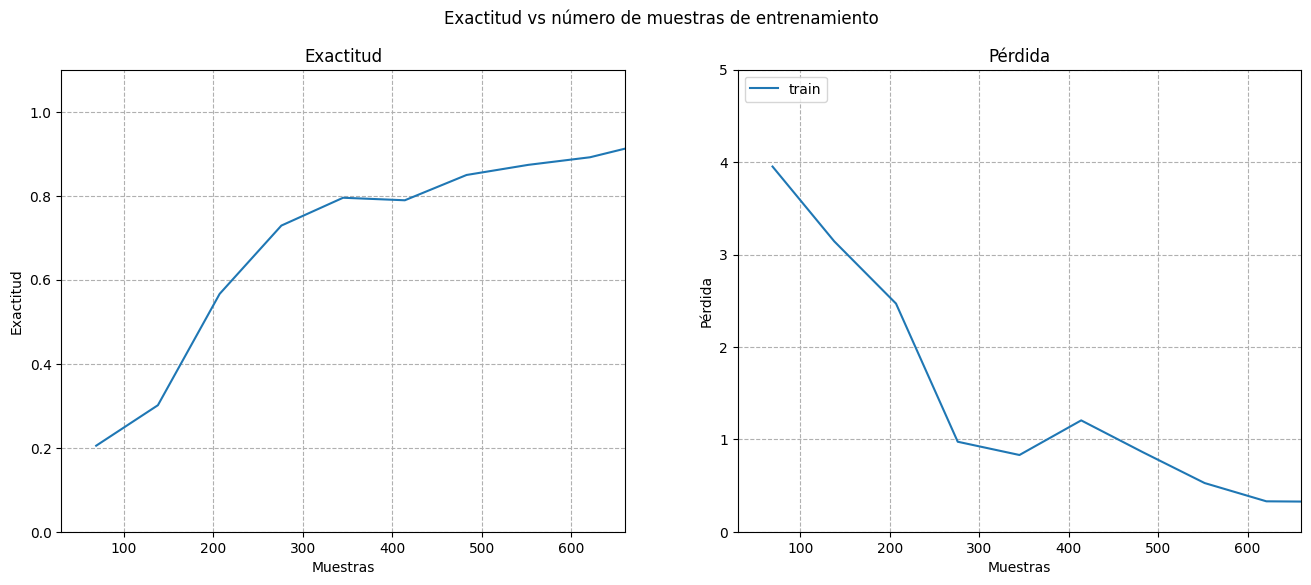

In [ ]:
from copy import copy

samp_X=copy(aug_X)
samp_y=copy(aug_y)
samp_y_inv=np.arange(len(samp_y))
for i in samp_y_inv:
    samp_y_inv[i]=inv_dict[samp_y[i]]

vec=(np.arange(12)+1)*69

acc_samples=[]
loss_samples=[]
for i in vec:
    train_xS, test_xS, train_yS, test_yS = train_test_split(samp_X, samp_y_inv, test_size = 0.2)

    train_ySOHE = to_categorical(train_yS, num_classes = 26, dtype='int') #Vectores de etiquetas convertidos a categorías en forma de One Hot Encoding
    test_ySOHE = to_categorical(test_yS, num_classes = 26, dtype='int')


    start_time = time.time()

    model_aug = Sequential()
    model_aug.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1))) #Convolución con 32 filtros (inicialmente generados aleatoriamente) con tamaño de kernel de 3x3
    model_aug.add(MaxPool2D(pool_size=(2, 2), strides=2)) #Reducción de la dimensionalidad de las convoluciones para reducir el coste computacional y evitar overfititng
    model_aug.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
    model_aug.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model_aug.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
    model_aug.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model_aug.add(Flatten())
    #Classification
    model_aug.add(Dense(64,activation ="relu"))
    model_aug.add(Dense(128,activation ="relu"))
    model_aug.add(Dense(26,activation ="softmax"))
    model_aug.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history_aug = model_aug.fit(train_xS[0:i,:,:,:], train_ySOHE[0:i,:], epochs=25, batch_size=32, validation_data = (test_x2,test_y2OHE), verbose=0) #Batch size default=32

    t= time.time()-start_time

    acc_samples=np.append(acc_samples, history_aug.history['val_accuracy'][-1])
    loss_samples=np.append(loss_samples, history_aug.history['val_loss'][-1])


plt.figure(2)
fig, axes = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Exactitud vs número de muestras de entrenamiento")


axes[0].plot(vec,acc_samples)
axes[0].set_title('Exactitud')
axes[0].set_ylabel('Exactitud')
axes[0].set_xlabel('Muestras')
#axes[0].legend(['train', 'test'], loc='upper left')
axes[0].grid(True, linestyle='--',)
axes[0].set_ylim([0,1.1])
axes[0].set_xlim([30,660])

axes[1].plot(vec,loss_samples)
axes[1].set_title('Pérdida')
axes[1].set_ylabel('Pérdida')
axes[1].set_xlabel('Muestras')
axes[1].legend(['train', 'test'], loc='upper left')
axes[1].grid(True, linestyle='--',)
axes[1].set_ylim([0,5])
axes[1].set_xlim([30,660])

#### 3.3 - Modificación de hiperparámetros

[Text(69, 1, 'Original'),
 Text(138, 1, 'Escalamiento'),
 Text(207, 1, ''),
 Text(276, 1, 'Rotación +15º'),
 Text(345, 1, ''),
 Text(414, 1, 'Rotación -15º'),
 Text(483, 1, ''),
 Text(552, 1, ''),
 Text(621, 1, ''),
 Text(690, 1, ''),
 Text(759, 1, ''),
 Text(828, 1, 'Inversión de color')]

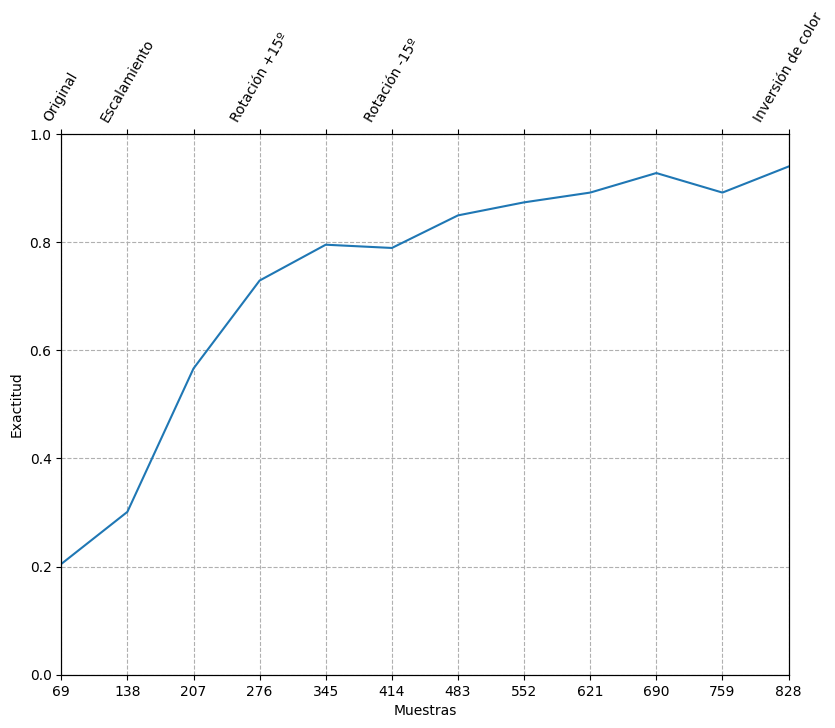

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(8,6))
#fig.suptitle("Exactitud vs número de muestras de entrenamiento")
fig.tight_layout()

lista_aug=['Original','Escalamiento','','Rotación +15º','','Rotación -15º','','','','','','Inversión de color']

ax2=axes.twiny()

axes.plot(vec,acc_samples)
axes.set_ylabel('Exactitud')
axes.set_xlabel('Muestras')
#axes[0].legend(['train', 'test'], loc='upper left')
axes.grid(True, linestyle='--',)
axes.set_ylim([0,1])
axes.set_xlim([69,828])
axes.set_xticks(vec)
ax2.set_xticks(vec)
ax2.set_xlim([69,828])
ax2.set_xticklabels(lista_aug, rotation=60)
#ax2.set_xlabel('Etapa de aumentación')


Se realizaron algunas pruebas adicionales para evaluar cómo la introducción y modificación de algunos parámetros aftecta el rendimiento de la red.

Se probó introducir dropout en las dos penúltimas capas, las cuales son capas de neuronas complentamente conectadas. El dropout supone eliminar la salida de un porcentaje determinado (dropout rate) de neuronas de manera aleatoria. En algunos casos es una herramienta útil para mejorar el rendimiento de las redes neuronales y reducir los signos de sobreentrenamiento. Se probaron diferentes porcentajes de dropout rate en este modelo, su rendimiento se muestra a continuación.

(0.0, 5.0)

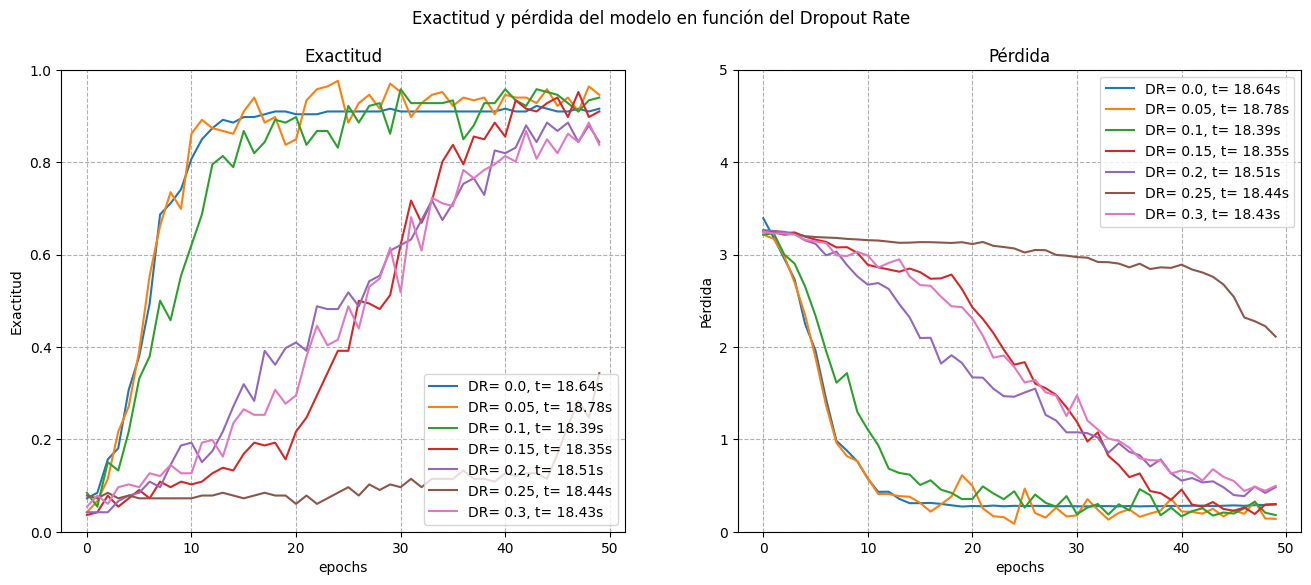

In [ ]:

vec=np.arange(7)*0.05
vec=np.around(vec,decimals=2)
timevec=[0]

fig, axes = plt.subplots(1,2, figsize=(16,6))
for i in vec:
    start_time = time.time()

    model_test = Sequential()
    model_test.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1))) #Convolución con 32 filtros (inicialmente generados aleatoriamente) con tamaño de kernel de 3x3
    model_test.add(MaxPool2D(pool_size=(2, 2), strides=2)) #Reducción de la dimensionalidad de las convoluciones para reducir el coste computacional y evitar overfititng
    model_test.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
    model_test.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model_test.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
    model_test.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model_test.add(Flatten())
    #Classification
    model_test.add(Dense(64,activation ="relu"))
    model_test.add(Dropout(i))
    model_test.add(Dense(128,activation ="relu"))
    model_test.add(Dropout(i))
    model_test.add(Dense(26,activation ="softmax"))
    model_test.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history_test = model_test.fit(train_x2, train_y2OHE, epochs=50, batch_size=32, validation_data = (test_x2,test_y2OHE), verbose=0) #Batch size default=32
    timevec=np.append(timevec,(time.time() - start_time))
    axes[0].plot(history_test.history['val_accuracy'])
    axes[0].grid 
    axes[1].plot(history_test.history['val_loss'])

timevec=timevec[1:len(timevec)]
vec2=[0,0,0,0,0,0,0]
timevec=np.around(timevec,decimals=2)
for i  in np.arange(len(vec)):
    vec2[i]="DR= "+str(vec[i])+", t= "+str(timevec[i])+"s"

fig.suptitle('Exactitud y pérdida del modelo en función del Dropout Rate')
axes[0].set_title('Exactitud')
axes[0].set_ylabel('Exactitud')
axes[0].set_xlabel('epochs')
axes[0].legend(vec2, loc='lower right')
axes[0].grid(True, linestyle='--',)
axes[0].set_ylim([0,1])

axes[1].set_title('Pérdida')
axes[1].set_ylabel('Pérdida')
axes[1].set_xlabel('epochs')
axes[1].legend(vec2, loc='upper right')
axes[1].grid(True, linestyle='--',)
axes[1].set_ylim([0,5])


Se probaron diferentes valores para el batch size del modelo. El batch size se refiere a la cantidad de muestras que el modelo utilizará en una iteración de entrenamiento. Entre menor sea el batch size, mayor será el número de iteraciones que deben realizarse durante el entrenamiento. Los valores utilizados son potencias de 2, ya que se consideran óptimos debido a la forma en la que la GPU realiza las operaciones.

(0.0, 5.0)

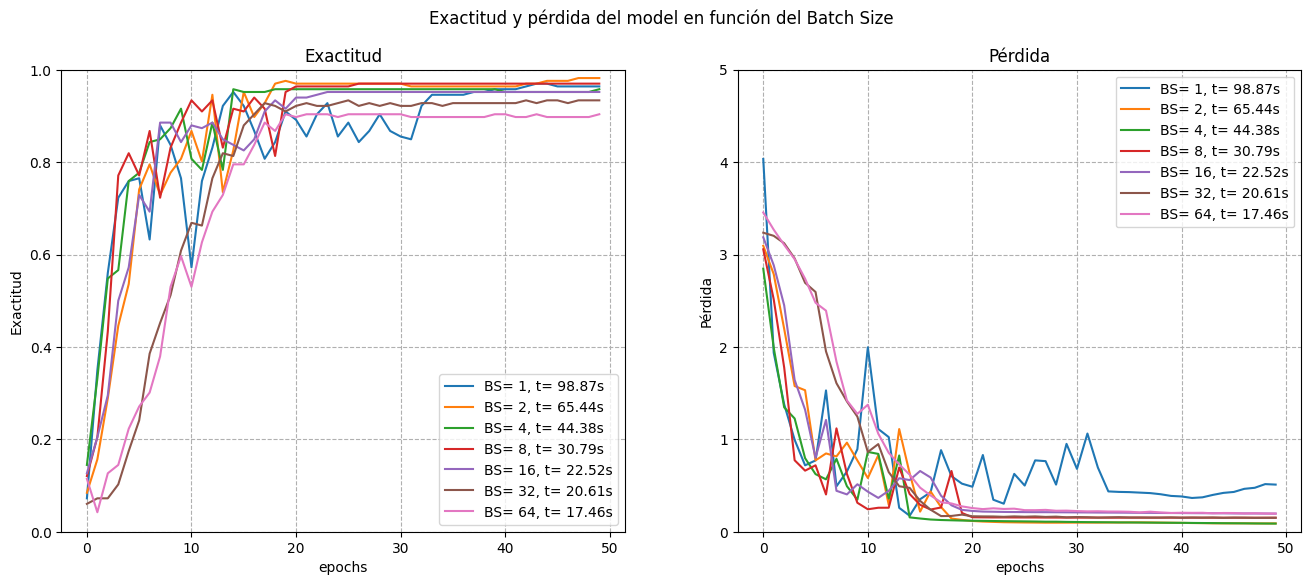

In [ ]:

vec=[1,2, 4, 8, 16, 32, 64]
timevec=[0]

fig, axes = plt.subplots(1,2, figsize=(16,6))
for i in vec:
    start_time = time.time()

    model_test = Sequential()
    model_test.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1))) #Convolución con 32 filtros (inicialmente generados aleatoriamente) con tamaño de kernel de 3x3
    model_test.add(MaxPool2D(pool_size=(2, 2), strides=2)) #Reducción de la dimensionalidad de las convoluciones para reducir el coste computacional y evitar overfititng
    model_test.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
    model_test.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model_test.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
    model_test.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model_test.add(Flatten())
    #Classification
    model_test.add(Dense(64,activation ="relu"))
    model_test.add(Dense(128,activation ="relu"))
    model_test.add(Dense(26,activation ="softmax"))
    model_test.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history_test = model_test.fit(train_x2, train_y2OHE, epochs=50, batch_size=i, validation_data = (test_x2,test_y2OHE), verbose=0) #Batch size default=32
    timevec=np.append(timevec,(time.time() - start_time))
    axes[0].plot(history_test.history['val_accuracy'])
    axes[0].grid 
    axes[1].plot(history_test.history['val_loss'])

timevec=timevec[1:len(timevec)]
timevec=np.around(timevec,decimals=2)
for i  in np.arange(len(vec)):
    vec[i]="BS= "+str(vec[i])+", t= "+str(timevec[i])+"s"

fig.suptitle('Exactitud y pérdida del model en función del Batch Size')
axes[0].set_title('Exactitud')
axes[0].set_ylabel('Exactitud')
axes[0].set_xlabel('epochs')
axes[0].legend(vec, loc='lower right')
axes[0].grid(True, linestyle='--',)
axes[0].set_ylim([0,1])

axes[1].set_title('Pérdida')
axes[1].set_ylabel('Pérdida')
axes[1].set_xlabel('epochs')
axes[1].legend(vec, loc='upper right')
axes[1].grid(True, linestyle='--',)
axes[1].set_ylim([0,5])

Se probaron diferentes valores de learning rate. El learning rate es un valor que controla en qué medida se ajustan los pesos de las neuronas después de cada iteración. 

(0.0, 5.0)

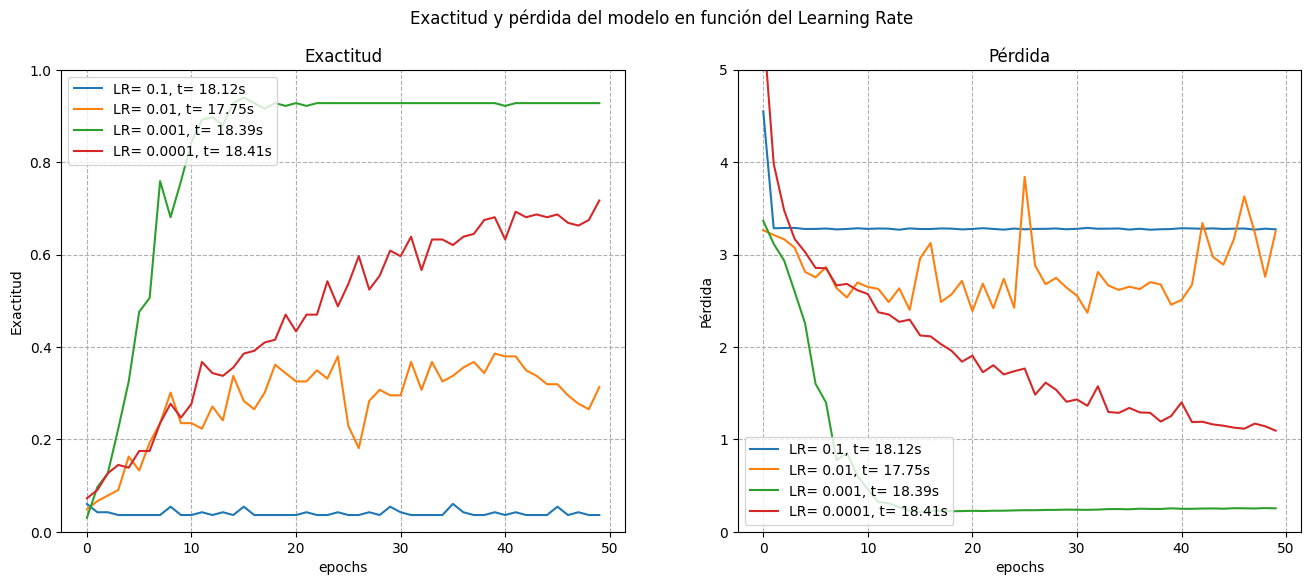

In [ ]:

vec=[0.1,0.01,0.001,0.0001]
timevec=[0]

fig, axes = plt.subplots(1,2, figsize=(16,6))
for i in vec:
    start_time = time.time()

    model_test = Sequential()
    model_test.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1))) #Convolución con 32 filtros (inicialmente generados aleatoriamente) con tamaño de kernel de 3x3
    model_test.add(MaxPool2D(pool_size=(2, 2), strides=2)) #Reducción de la dimensionalidad de las convoluciones para reducir el coste computacional y evitar overfititng
    model_test.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
    model_test.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model_test.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
    model_test.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model_test.add(Flatten())
    #Classification
    model_test.add(Dense(64,activation ="relu"))
    model_test.add(Dense(128,activation ="relu"))
    model_test.add(Dense(26,activation ="softmax"))
    model_test.compile(optimizer = Adam(learning_rate=i), loss='categorical_crossentropy', metrics=['accuracy'])
    history_test = model_test.fit(train_x2, train_y2OHE, epochs=50, batch_size=32, validation_data = (test_x2,test_y2OHE), verbose=0) #Batch size default=32
    timevec=np.append(timevec,(time.time() - start_time))
    axes[0].plot(history_test.history['val_accuracy'])
    axes[0].grid 
    axes[1].plot(history_test.history['val_loss'])

timevec=timevec[1:5]
timevec=np.around(timevec,decimals=2)
for i  in np.arange(len(vec)):
    vec[i]="LR= "+str(vec[i])+", t= "+str(timevec[i])+"s"

fig.suptitle('Exactitud y pérdida del modelo en función del Learning Rate')
axes[0].set_title('Exactitud')
axes[0].set_ylabel('Exactitud')
axes[0].set_xlabel('epochs')
axes[0].legend(vec, loc='upper left')
axes[0].grid(True, linestyle='--',)
axes[0].set_ylim([0,1])

axes[1].set_title('Pérdida')
axes[1].set_ylabel('Pérdida')
axes[1].set_xlabel('epochs')
axes[1].legend(vec, loc='lower left')
axes[1].grid(True, linestyle='--',)
axes[1].set_ylim([0,5])


#### 3.4 - Fine-tuning del modelo

A partir de las pruebas realizadas anteriormente, se ajustaron algunos hiperparámetros del modelo de la sección 3.2 con el objetivo de optimizar su exactitud. Se escogió un batch size=2 y learning rate=0.001. Se optó por no añadir dropout al modelo. La exactitud final observada es de 0.9819.

Model: "sequential_191"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_573 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_573 (MaxPool  (None, 13, 13, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_574 (Conv2D)         (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_574 (MaxPool  (None, 6, 6, 64)          0         
 ing2D)                                                          
                                                                 
 conv2d_575 (Conv2D)         (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_575 (MaxPool  (None, 2, 2, 128)      

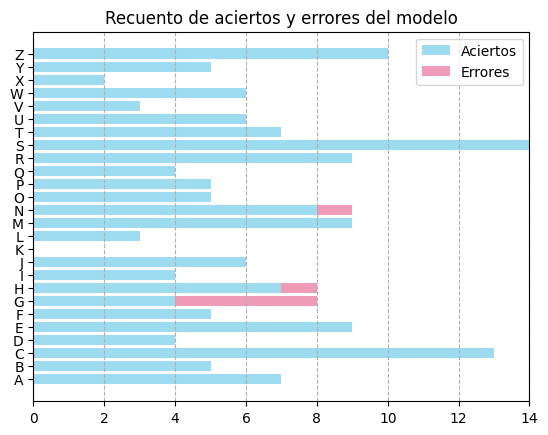

(0.0, 5.0)

<Figure size 640x480 with 0 Axes>

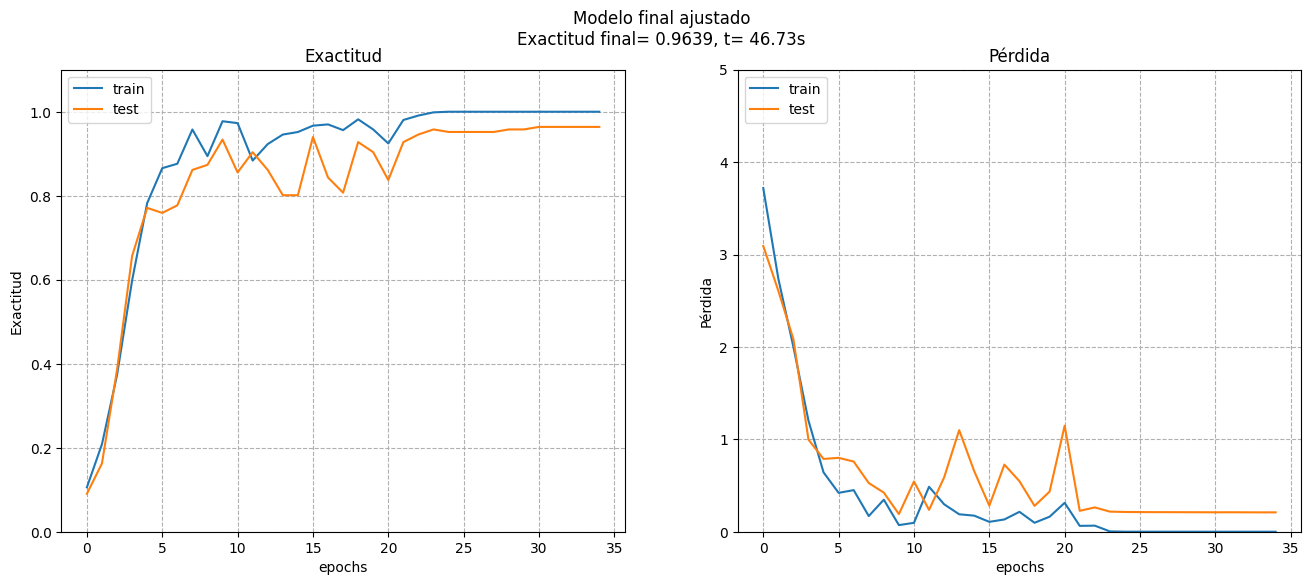

In [ ]:
start_time = time.time()
model_fin = Sequential()
model_fin.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1))) #Convolución con 32 filtros (inicialmente generados aleatoriamente) con tamaño de kernel de 3x3
model_fin.add(MaxPool2D(pool_size=(2, 2), strides=2)) #Reducción de la dimensionalidad de las convoluciones para reducir el coste computacional y evitar overfititng
model_fin.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model_fin.add(MaxPool2D(pool_size=(2, 2), strides=2))
model_fin.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model_fin.add(MaxPool2D(pool_size=(2, 2), strides=2))
model_fin.add(Flatten())
#Classification
model_fin.add(Dense(64,activation ="relu"))
#model_fin.add(Dropout(0.01))
model_fin.add(Dense(128,activation ="relu"))
#model_fin.add(Dropout(0.01))
model_fin.add(Dense(26,activation ="softmax"))
model_fin.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_fin.summary()
history_fin = model_fin.fit(train_x2, train_y2OHE, epochs=35, batch_size=2, validation_data = (test_x2,test_y2OHE), verbose=0) #Batch size default=32
t= time.time()-start_time

pred_fin = model_fin.predict(test_x2)
pred_noOHE=[]
acc=np.zeros((len(pred_fin)))
for i in np.arange(len(acc)):
    label = word_dict[np.argmax(pred_fin[i])]
    correct = word_dict[np.argmax(test_y2OHE[i])]
    if label == correct:
        acc[i]=1
    pred_noOHE=np.append(pred_noOHE,correct)
pred_matrix={"Letter": pred_noOHE, "Correct": acc}
pred_df = pd.DataFrame(pred_matrix)

alph=list(map(chr, range(65, 91)))
right=[]
wrong=[]
for i in alph:
    m = sum((pred_df.Letter == i) & (pred_df.Correct == 1))
    m_2 = sum((pred_df.Letter == i) & (pred_df.Correct == 0))
    right=np.append(right,m)
    wrong=np.append(wrong,m_2)
plt.figure(1)
plt.barh(alph, right, color='#9cdbf0')
plt.barh(alph, wrong, left=right, color='#f09cb9')
plt.grid(True, axis='x', linestyle='--',)
plt.legend(['Aciertos', 'Errores'], loc='upper right')
plt.title('Recuento de aciertos y errores del modelo')
plt.show()

plt.figure(2)
fig, axes = plt.subplots(1,2, figsize=(16,6))

fig.suptitle("Modelo final ajustado\nExactitud final= "+str(np.around(history_fin.history['val_accuracy'][len(history_fin.history['val_accuracy'])-1], decimals=4))+", t= "+str(np.around(t, decimals=2))+"s")

axes[0].plot(history_fin.history['accuracy'])
axes[0].plot(history_fin.history['val_accuracy'])
axes[0].set_title('Exactitud')
axes[0].set_ylabel('Exactitud')
axes[0].set_xlabel('epochs')
axes[0].legend(['train', 'test'], loc='upper left')
axes[0].grid(True, linestyle='--',)
axes[0].set_ylim([0,1.1])

axes[1].plot(history_fin.history['loss'])
axes[1].plot(history_fin.history['val_loss'])
axes[1].set_title('Pérdida')
axes[1].set_ylabel('Pérdida')
axes[1].set_xlabel('epochs')
axes[1].legend(['train', 'test'], loc='upper left')
axes[1].grid(True, linestyle='--',)
axes[1].set_ylim([0,5])




#### Anexo 1 - Prueba de robustez - Introducción de ruido

Se probó la robustez del modelo evaluando su exactitud cuando las imágenes de prueba contienen una cantidad determinada de ruido. Se experimentó con dos estrategias de introducción de ruido: Suma ponderada de imágenes de ruido y modifiación de pixeles aleatorios. 

La primer estrategia consiste en, para cada muestra, generar una imagen aleatoria de ruido para posteriormente sumarla a la muestra de manera ponderada. 

A continuación se muestran 5 imágenes diferentes con determinados porcentajes de ruido. El porcentaje en este caso indica la proporción con la cual se sumó la imagen de ruido. 

Text(0.5, 1.0, '100% Ruido')

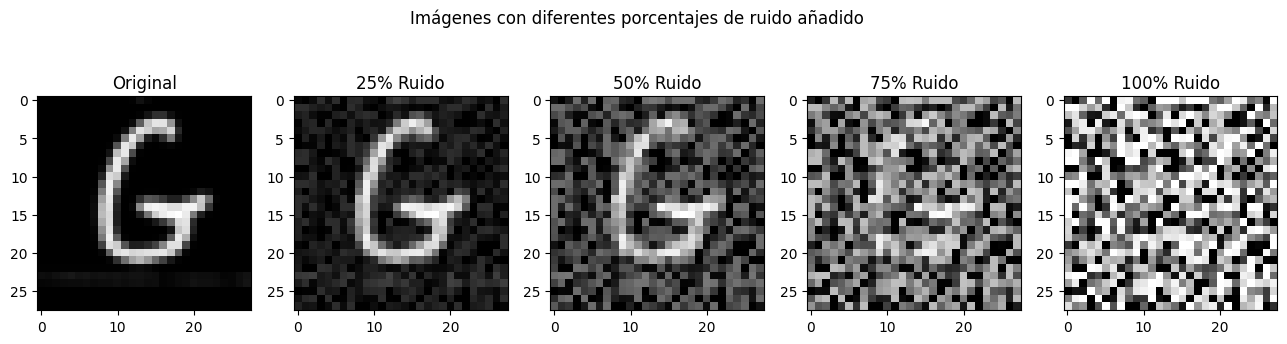

In [ ]:
index=200

gauss_noise=np.zeros((28,28),dtype=np.uint8)
cv2.randn(gauss_noise,128,128)
gauss_noise=(gauss_noise*0.5).astype(np.float64)
a=0.25
b=1-a
img_noise25=cv2.addWeighted(train_x2[index],b,gauss_noise,a,0)

a=0.50
b=1-a
img_noise50=cv2.addWeighted(train_x2[index],b,gauss_noise,a,0)

a=0.75
b=1-a
img_noise75=cv2.addWeighted(train_x2[index],b,gauss_noise,a,0)


fig, axes = plt.subplots(1,5, figsize=(16,4))
fig.suptitle("Imágenes con diferentes porcentajes de ruido añadido")


axes[0].imshow(train_x2[index], cmap="Greys")
axes[0].set_title("Original")
axes[1].imshow(img_noise25, cmap="Greys")
axes[1].set_title("25% Ruido")
axes[2].imshow(img_noise50, cmap="Greys")
axes[2].set_title("50% Ruido")
axes[3].imshow(img_noise75, cmap="Greys")
axes[3].set_title("75% Ruido")
axes[4].imshow(gauss_noise, cmap="Greys")
axes[4].set_title("100% Ruido")


Se evaluó la exactitud del modelo en función del porcentaje de ruido añadido.

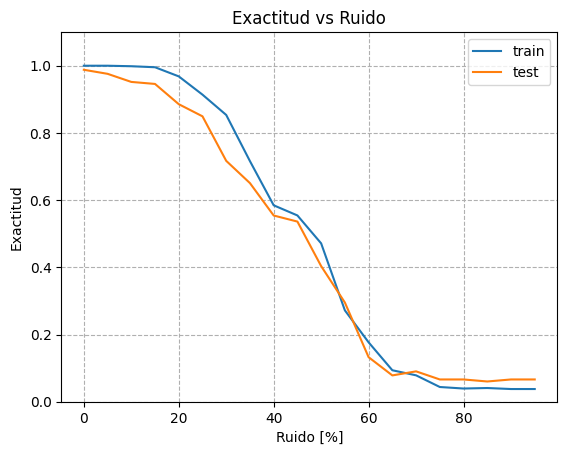

In [ ]:
vec=np.arange(20)*0.05
vec=np.around(vec,decimals=2)
noise_acc_train=[]
noise_acc_test=[]
for i in vec:
    noise_X=np.zeros((28,28))
    noise_X=np.expand_dims(noise_X, axis=0)
    noise_X=np.expand_dims(noise_X, axis=3)
    gauss_noise=np.zeros((28,28),dtype=np.uint8)
    cv2.randn(gauss_noise,128,128)
    gauss_noise=(gauss_noise*0.5).astype(np.float64)
    a=i
    b=1-a
    for i in np.arange(len(train_x2)):
        img_noise=cv2.addWeighted(train_x2[i],b,gauss_noise,a,0)
        img_noise =np.expand_dims(img_noise, axis=0)
        img_noise =np.expand_dims(img_noise, axis=3)
        noise_X = np.append(noise_X,img_noise, axis=0)
    noise_X=noise_X[1:len(noise_X)]
    history_noise=model_fin.evaluate(noise_X, train_y2OHE, verbose=0)
    noise_acc_train=np.append(noise_acc_train, history_noise[1])

for i in vec:
    noise_X=np.zeros((28,28))
    noise_X=np.expand_dims(noise_X, axis=0)
    noise_X=np.expand_dims(noise_X, axis=3)
    gauss_noise=np.zeros((28,28),dtype=np.uint8)
    cv2.randn(gauss_noise,128,128)
    gauss_noise=(gauss_noise*0.5).astype(np.float64) 
    a=i
    b=1-a
    for i in np.arange(len(test_x2)):
        img_noise=cv2.addWeighted(test_x2[i],b,gauss_noise,a,0)
        img_noise =np.expand_dims(img_noise, axis=0)
        img_noise =np.expand_dims(img_noise, axis=3)
        noise_X = np.append(noise_X,img_noise, axis=0)
    noise_X=noise_X[1:len(noise_X)]
    history_noise=model_fin.evaluate(noise_X, test_y2OHE, verbose=0)
    noise_acc_test=np.append(noise_acc_test, history_noise[1])

plt.plot(vec*100,noise_acc_train)
plt.plot(vec*100,noise_acc_test)
plt.title('Exactitud vs Ruido')
plt.ylabel('Exactitud')
plt.xlabel('Ruido [%]')
plt.grid(True, linestyle='--',)
plt.ylim([0,1.1])
plt.legend(['train', 'test'], loc='upper right')

La segunda estrategia consiste en seleccionar pixeles aleatorios y modificar los valores de esos pixeles a un valor aleatorio. En este caso el ruido se cuantifica como la proporción de pixeles en la imagen que han sido modificados, de forma que un 25% de ruido significa que el 25% de los pixeles contienen un valor aleatorio. A continuación se muestran algunos ejemplos a diferentes niveles de ruido.

Text(0.5, 1.0, '100% Ruido')

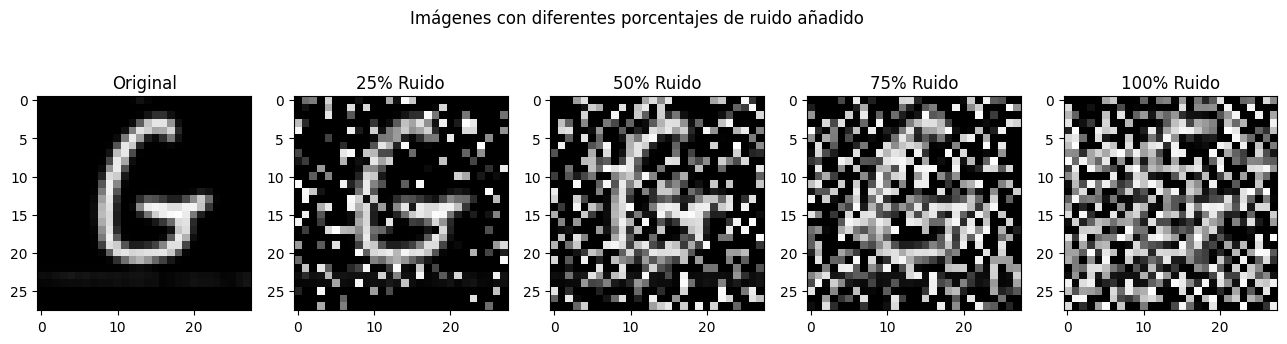

In [ ]:
from copy import copy
index=200

original=copy(train_x2[index,:,:,:])
noisepctg=0.25
vec=28*28*noisepctg
img_noise25=copy(original)
for i in np.arange(vec):
    coordx= random.randint(0, 27)
    coordy= random.randint(0, 27)
    img_noise25[coordx,coordy,:]=random.randint(0,255)

noisepctg=0.50
vec=28*28*noisepctg
img_noise50=copy(original)
for i in np.arange(vec):
    coordx= random.randint(0, 27)
    coordy= random.randint(0, 27)
    img_noise50[coordx,coordy,:]=random.randint(0,255)

noisepctg=0.75
vec=28*28*noisepctg
img_noise75=copy(original)
for i in np.arange(vec):
    coordx= random.randint(0, 27)
    coordy= random.randint(0, 27)
    img_noise75[coordx,coordy,:]=random.randint(0,255)

noisepctg=1
vec=28*28*noisepctg
img_noise100=copy(original)
for i in np.arange(vec):
    coordx= random.randint(0, 27)
    coordy= random.randint(0, 27)
    img_noise100[coordx,coordy,:]=random.randint(0,255)

fig, axes = plt.subplots(1,5, figsize=(16,4))
fig.suptitle("Imágenes con diferentes porcentajes de ruido añadido")


axes[0].imshow(train_x2[index], cmap="Greys")
axes[0].set_title("Original")
axes[1].imshow(img_noise25, cmap="Greys")
axes[1].set_title("25% Ruido")
axes[2].imshow(img_noise50, cmap="Greys")
axes[2].set_title("50% Ruido")
axes[3].imshow(img_noise75, cmap="Greys")
axes[3].set_title("75% Ruido")
axes[4].imshow(img_noise100, cmap="Greys")
axes[4].set_title("100% Ruido")


Se evaluó la exactitud del modelo en función del porcentaje de ruido añadido.

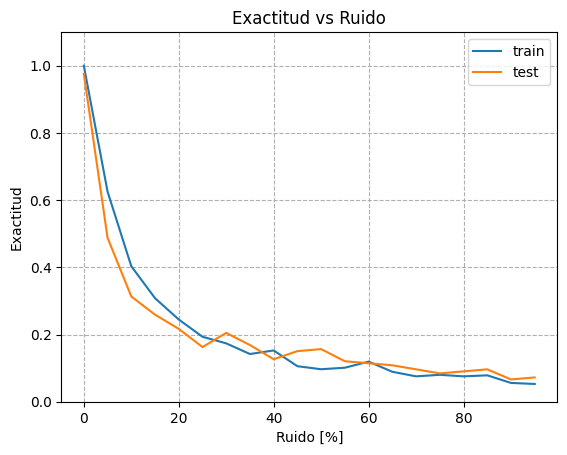

In [ ]:
vector=np.arange(20)*0.05
#vector=np.around(vec,decimals=2)
noise_acc_train=[]
noise_acc_test=[]
for i in vector:
    noise_X=np.zeros((28,28))
    noise_X=np.expand_dims(noise_X, axis=0)
    noise_X=np.expand_dims(noise_X, axis=3)
    noisepctg=i
    vec=28*28*noisepctg
    img_noise75=copy(original)
    for i in np.arange(len(train_x2)):
        img_noise=copy(train_x2[i])
        for i in np.arange(vec):
            coordx= random.randint(0, 27)
            coordy= random.randint(0, 27)
            img_noise[coordx,coordy,:]=random.randint(0,255)
        img_noise =np.expand_dims(img_noise, axis=0)
        #img_noise =np.expand_dims(img_noise, axis=3)
        noise_X = np.append(noise_X,img_noise, axis=0)
    noise_X=noise_X[1:len(noise_X)]
    history_noise=model_fin.evaluate(noise_X, train_y2OHE, verbose=0)
    noise_acc_train=np.append(noise_acc_train, history_noise[1])


for i in vector:
    noise_X=np.zeros((28,28))
    noise_X=np.expand_dims(noise_X, axis=0)
    noise_X=np.expand_dims(noise_X, axis=3)
    noisepctg=i
    vec=28*28*noisepctg
    img_noise75=copy(original)
    for i in np.arange(len(test_x2)):
        img_noise=copy(test_x2[i])
        for i in np.arange(vec):
            coordx= random.randint(0, 27)
            coordy= random.randint(0, 27)
            img_noise[coordx,coordy,:]=random.randint(0,255)
        img_noise =np.expand_dims(img_noise, axis=0)
        #img_noise =np.expand_dims(img_noise, axis=3)
        noise_X = np.append(noise_X,img_noise, axis=0)
    noise_X=noise_X[1:len(noise_X)]
    history_noise=model_fin.evaluate(noise_X, test_y2OHE, verbose=0)
    noise_acc_test=np.append(noise_acc_test, history_noise[1])

plt.plot(vector*100,noise_acc_train)
plt.plot(vector*100,noise_acc_test)
plt.title('Exactitud vs Ruido')
plt.ylabel('Exactitud')
plt.xlabel('Ruido [%]')
plt.grid(True, linestyle='--',)
plt.ylim([0,1.1])
plt.legend(['train', 'test'], loc='upper right')

### Anexo 2 - Estrategia de mitigación de sobreentrenamiento

Se entrenó un modelo de manera que se observara una gran diferencia entre el rendimiento con datos de entrenamiento y con datos de prueba. Este es un signo de un modelo sobreentrenado. Para esto, se modificaron los siguientes parámetros con respecto al modelo de la sección 3.4:
* Reducción del número de muestras de entrenamiento a 100
* Capas densas con un número mayor de neuronas (256 y 1048, comparado con 64 y 128 anteriormente)
* Número elevado de epochs

Posteriormente se intentará buscar soluciones para reducir los signos de sobreentrenamiento.

(0.0, 5.0)

<Figure size 640x480 with 0 Axes>

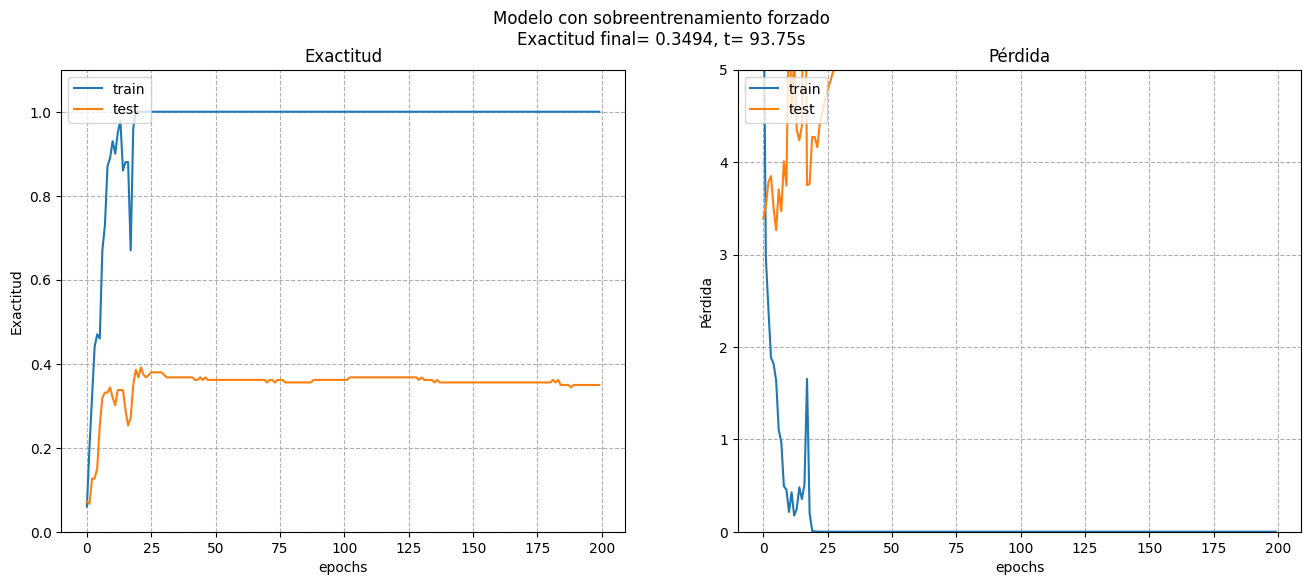

In [14]:
start_time = time.time()
model_fin = Sequential()
model_fin.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1))) #Convolución con 32 filtros (inicialmente generados aleatoriamente) con tamaño de kernel de 3x3
model_fin.add(MaxPool2D(pool_size=(2, 2), strides=2)) #Reducción de la dimensionalidad de las convoluciones para reducir el coste computacional y evitar overfititng
model_fin.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model_fin.add(MaxPool2D(pool_size=(2, 2), strides=2))
model_fin.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model_fin.add(MaxPool2D(pool_size=(2, 2), strides=2))
model_fin.add(Flatten())
#Classification
model_fin.add(Dense(256,activation ="relu"))
#model_fin.add(Dropout(0.01))
model_fin.add(Dense(1048,activation ="relu"))
#model_fin.add(Dropout(0.01))
model_fin.add(Dense(26,activation ="softmax"))
model_fin.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_fin = model_fin.fit(train_x2[0:100], train_y2OHE[0:100], epochs=200, batch_size=2, validation_data = (test_x2,test_y2OHE), verbose=0) #Batch size default=32
t= time.time()-start_time

plt.figure(2)
fig, axes = plt.subplots(1,2, figsize=(16,6))

fig.suptitle("Modelo con sobreentrenamiento forzado\nExactitud final= "+str(np.around(history_fin.history['val_accuracy'][len(history_fin.history['val_accuracy'])-1], decimals=4))+", t= "+str(np.around(t, decimals=2))+"s")

axes[0].plot(history_fin.history['accuracy'])
axes[0].plot(history_fin.history['val_accuracy'])
axes[0].set_title('Exactitud')
axes[0].set_ylabel('Exactitud')
axes[0].set_xlabel('epochs')
axes[0].legend(['train', 'test'], loc='upper left')
axes[0].grid(True, linestyle='--',)
axes[0].set_ylim([0,1.1])

axes[1].plot(history_fin.history['loss'])
axes[1].plot(history_fin.history['val_loss'])
axes[1].set_title('Pérdida')
axes[1].set_ylabel('Pérdida')
axes[1].set_xlabel('epochs')
axes[1].legend(['train', 'test'], loc='upper left')
axes[1].grid(True, linestyle='--',)
axes[1].set_ylim([0,5])

Para intentar mejorar el rendimiento del modelo se realizaron algunas modificaciones:
* Introducción de droupout de 0.1 en las capas densas del modelo.
* Cambio del optimizador a **SGD**, una versión más sencilla del optimizador utilizado anteriormente (Adam).
* Introducción de  ***weight decay*** de 0.1. El weight decay es un valor que se suma a la función de pérdida para prevenir que los pesos del modelo se vuelvan demasiado grandes.

Utilizando estos ajustes se puede observar una especial mejora en la pérdida del modelo. Igualmente incrementa en alrededor de 0.07 el valor de exactitud. 

(0.0, 5.0)

<Figure size 640x480 with 0 Axes>

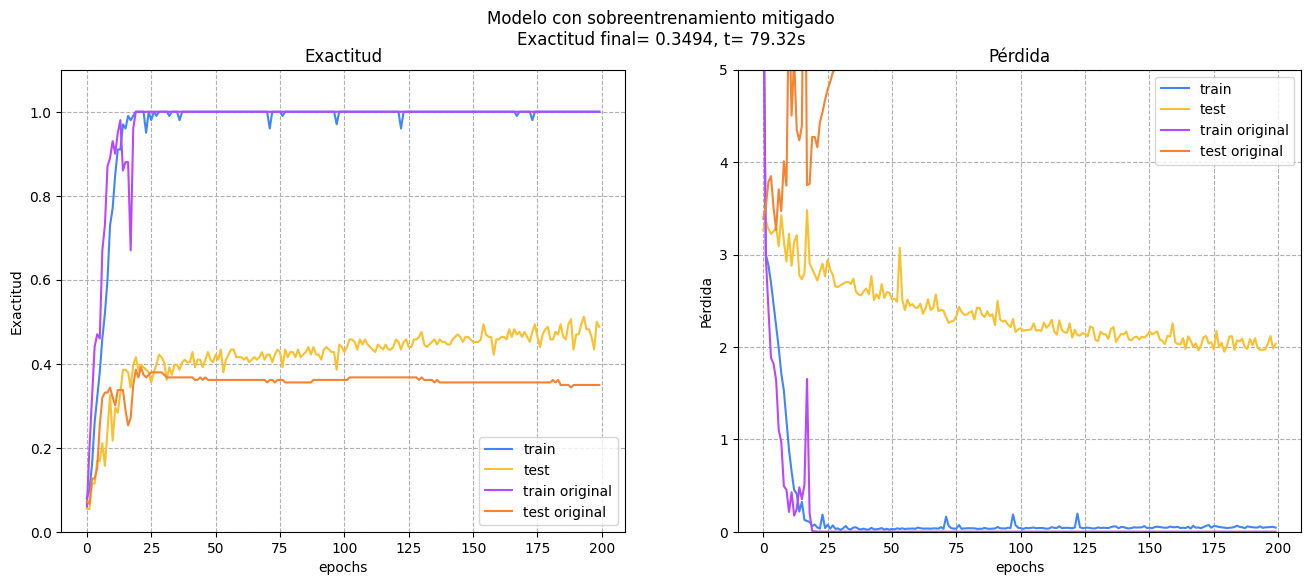

In [18]:
start_time = time.time()
model_fin = Sequential()
model_fin.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1))) #Convolución con 32 filtros (inicialmente generados aleatoriamente) con tamaño de kernel de 3x3
model_fin.add(MaxPool2D(pool_size=(2, 2), strides=2)) #Reducción de la dimensionalidad de las convoluciones para reducir el coste computacional y evitar overfititng
model_fin.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model_fin.add(MaxPool2D(pool_size=(2, 2), strides=2))
model_fin.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model_fin.add(MaxPool2D(pool_size=(2, 2), strides=2))
model_fin.add(Flatten())
#Classification
model_fin.add(Dense(256,activation ="relu"))
model_fin.add(Dropout(0.1))
model_fin.add(Dense(1048,activation ="relu"))
model_fin.add(Dropout(0.1))
model_fin.add(Dense(26,activation ="softmax"))
model_fin.compile(optimizer = SGD(learning_rate=0.001, weight_decay=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
history_fin2 = model_fin.fit(train_x2[0:100], train_y2OHE[0:100], epochs=200, batch_size=2, validation_data = (test_x2,test_y2OHE), verbose=0) #Batch size default=32
t= time.time()-start_time

plt.figure(2)
fig, axes = plt.subplots(1,2, figsize=(16,6))

fig.suptitle("Modelo con sobreentrenamiento mitigado\nExactitud final= "+str(np.around(history_fin.history['val_accuracy'][len(history_fin.history['val_accuracy'])-1], decimals=4))+", t= "+str(np.around(t, decimals=2))+"s")

axes[0].plot(history_fin2.history['accuracy'], color='#3e86fa')
axes[0].plot(history_fin2.history['val_accuracy'], color= '#fac02d')
axes[0].plot(history_fin.history['accuracy'], color='#b947ff')
axes[0].plot(history_fin.history['val_accuracy'], color='#f7822f')
axes[0].set_title('Exactitud')
axes[0].set_ylabel('Exactitud')
axes[0].set_xlabel('epochs')
axes[0].legend(['train', 'test','train original', 'test original'], loc='lower right')
axes[0].grid(True, linestyle='--',)
axes[0].set_ylim([0,1.1])

axes[1].plot(history_fin2.history['loss'], color='#3e86fa')
axes[1].plot(history_fin2.history['val_loss'], color='#fac02d')
axes[1].plot(history_fin.history['loss'], color='#b947ff')
axes[1].plot(history_fin.history['val_loss'], color='#f7822f')
axes[1].set_title('Pérdida')
axes[1].set_ylabel('Pérdida')
axes[1].set_xlabel('epochs')
axes[1].legend(['train', 'test','train original', 'test original'], loc='upper right')
axes[1].grid(True, linestyle='--',)
axes[1].set_ylim([0,5])

#### Anexo 3 - Visualización de filtros y sus salidas

En esta sección se pueden visualizar algunos de los filtros usados en las capas internas del modelo. La primera figura muestra los filtros utilizados por la primera capa de convolución para la extracción de características de las imágenes. Cada filtro es una matriz de 3x3 que realiza operaciones de convolución en las imágenes. Los resultados de estas operaciones se pueden observar para cada filtro, en la segunda figura.

Text(0.5, 0.98, 'Filtros de la primera capa de convolución')

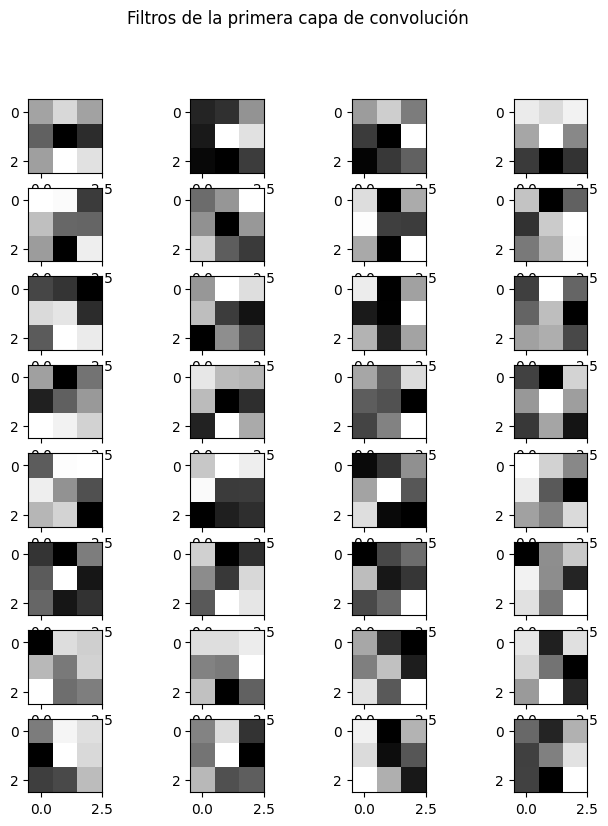

In [ ]:

filters , bias = model_fin.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

fig, axes = plt.subplots(8,4, figsize=(8,9))
axes = axes.flatten()

for i,ax in enumerate(axes): #Se enumeran los subplots y las imágenes predichas (no me gusta el comment tbh)
    f = filters[:,:,:,i]
    ax.imshow(f ,cmap='gray')
fig.suptitle('Filtros de la primera capa de convolución')

Salida

1/1 [==============================] - 0s 46ms/step


Text(0.5, 0.98, 'Imágenes de salida de la primera capa de convolución')

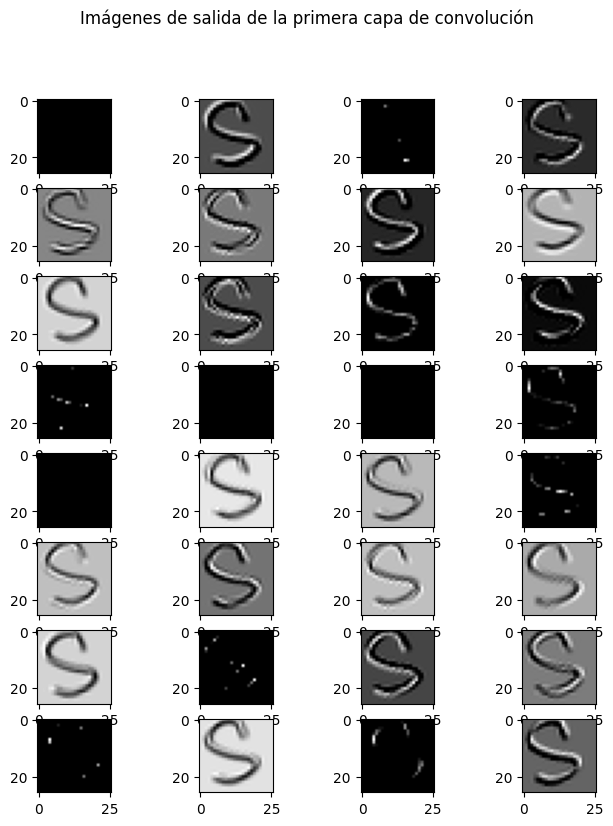

In [ ]:

model_3 = Sequential()
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1))) #Convolución con 32 filtros (inicialmente generados aleatoriamente) con tamaño de kernel de 3x3
model_3.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#history_3 = model_3.fit(train_x2, train_y2OHE, epochs=35, batch_size=2, validation_data = (test_x2,test_y2OHE), verbose=0) #Batch size default=32
pred3=model_3.predict(aug_X[27+69*2:48+69*2])

fig, axes = plt.subplots(8,4, figsize=(8,9))
axes = axes.flatten()

for i,ax in enumerate(axes): #Se enumeran los subplots y las imágenes predichas (no me gusta el comment tbh)
    p = pred3[0,:,:,i]
    ax.imshow(p ,cmap='gray')
fig.suptitle('Imágenes de salida de la primera capa de convolución')

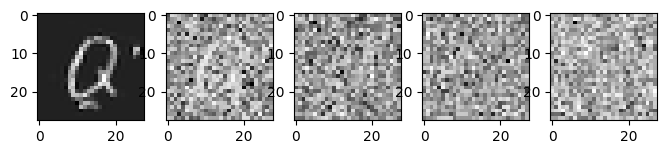

In [ ]:
from copy import copy
from random import gauss
index=80


img_noise0=copy(original)
img_noise0=np.reshape(img_noise0,(len(original)**2))
desvesta=0

for i in np.arange(len(img_noise0)):
    noise=random.gauss(-desvesta, desvesta)
    img_noise0[i]=img_noise0[i]+noise*img_noise0[i]
img_noise0=np.reshape(img_noise0,(28,28))

img_noise25=copy(original)
img_noise25=np.reshape(img_noise25,(len(original)**2))
desvesta=0.25

for i in np.arange(len(img_noise25)):
    noise=random.gauss(-desvesta, desvesta)
    img_noise25[i]=img_noise25[i]+noise*img_noise25[i]
img_noise25=np.reshape(img_noise25,(28,28))


img_noise50=copy(original)
img_noise50=np.reshape(img_noise50,(len(original)**2))
desvesta=0.50

for i in np.arange(len(img_noise50)):
    noise=random.gauss(-desvesta, desvesta)
    img_noise50[i]=img_noise50[i]+noise*img_noise50[i]
img_noise50=np.reshape(img_noise50,(28,28))

img_noise75=copy(original)
img_noise75=np.reshape(img_noise75,(len(original)**2))
desvesta=0.75

for i in np.arange(len(img_noise75)):
    noise=random.gauss(-desvesta, desvesta)
    img_noise75[i]=img_noise75[i]+noise*img_noise75[i]
img_noise75=np.reshape(img_noise75,(28,28))

img_noise100=copy(original)
img_noise100=np.reshape(img_noise100,(len(original)**2))
desvesta=1

for i in np.arange(len(img_noise100)):
    noise=random.gauss(-desvesta, desvesta)
    img_noise100[i]=img_noise100[i]+noise*img_noise100[i]
img_noise100=np.reshape(img_noise100,(28,28))


fig, axes = plt.subplots(1,5, figsize=(8,9))
axes[0].imshow(original, cmap="Greys")
axes[1].imshow(img_noise25, cmap="Greys")
axes[2].imshow(img_noise50, cmap="Greys")
axes[3].imshow(img_noise75, cmap="Greys")
axes[4].imshow(img_noise100, cmap="Greys")

In [ ]:
index=200

gauss_noise=np.zeros((28,28),dtype=np.uint8)
cv2.randn(gauss_noise,128,128)
gauss_noise=(gauss_noise*0.5).astype(np.float64)
a=0.25
b=1-a
img_noise25=cv2.addWeighted(train_x2[index],b,gauss_noise,a,0)

a=0.50
b=1-a
img_noise50=cv2.addWeighted(train_x2[index],b,gauss_noise,a,0)

a=0.75
b=1-a
img_noise75=cv2.addWeighted(train_x2[index],b,gauss_noise,a,0)


fig, axes = plt.subplots(1,5, figsize=(16,4))
fig.suptitle("Imágenes con diferentes porcentajes de ruido añadido")


axes[0].imshow(train_x2[index], cmap="Greys")
axes[0].set_title("Original")
axes[1].imshow(img_noise25, cmap="Greys")
axes[1].set_title("25% Ruido")
axes[2].imshow(img_noise50, cmap="Greys")
axes[2].set_title("50% Ruido")
axes[3].imshow(img_noise75, cmap="Greys")
axes[3].set_title("75% Ruido")
axes[4].imshow(gauss_noise, cmap="Greys")

Text(0.5, 1.0, 'σ=1')

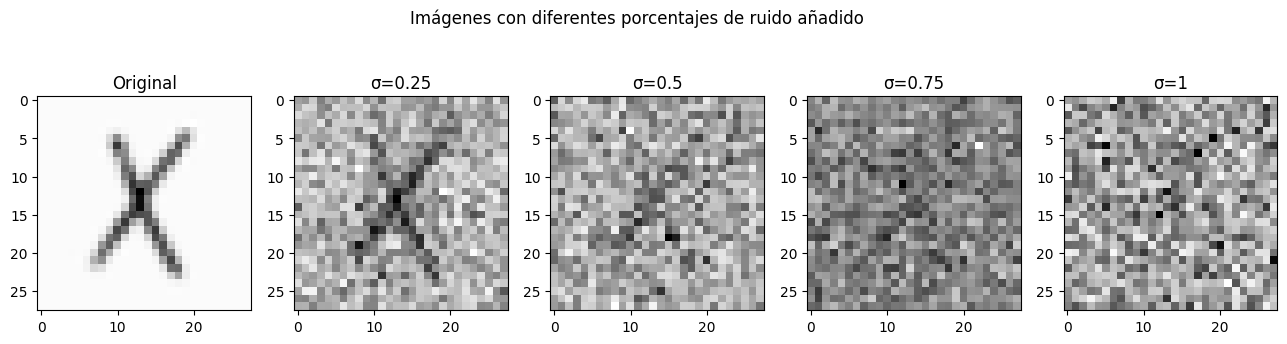

In [ ]:
index=25

def gaussnoise(original, desvesta):
    img_noise0=copy(original)
    img_noise0=np.reshape(img_noise0,(len(original)**2))

    for i in np.arange(len(img_noise0)):
        noise=random.gauss(0, desvesta)*255
        newval=img_noise0[i]+noise
        img_noise0[i]=newval
    img_noise0=np.reshape(img_noise0,(28,28))
    return img_noise0

original=copy(train_x2[index,:,:,:])
fig, axes = plt.subplots(1,5, figsize=(16,4))
fig.suptitle("Imágenes con diferentes porcentajes de ruido añadido")


axes[0].imshow(gaussnoise(original, 0), cmap="Greys")
axes[0].set_title("Original")
axes[1].imshow(gaussnoise(original, 0.25), cmap="Greys")
axes[1].set_title("σ=0.25")
axes[2].imshow(gaussnoise(original, 0.5), cmap="Greys")
axes[2].set_title("σ=0.5")
axes[3].imshow(gaussnoise(original, 0.75), cmap="Greys")
axes[3].set_title("σ=0.75")
axes[4].imshow(gaussnoise(original, 1), cmap="Greys")
axes[4].set_title("σ=1")

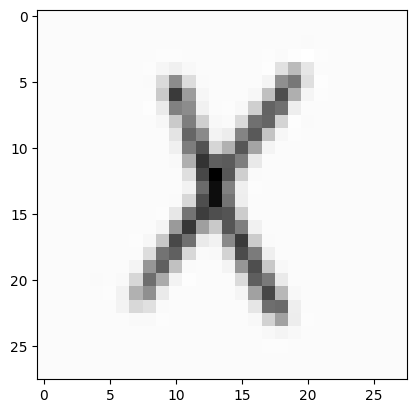

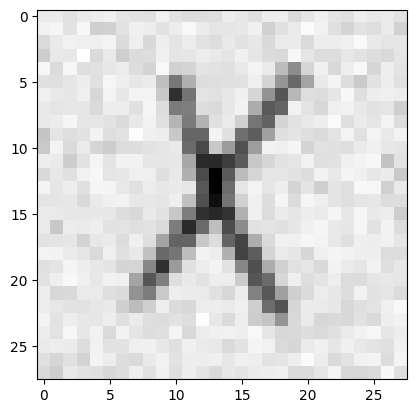

In [ ]:

from copy import copy
from random import gauss
index=25

original=copy(train_x2[index,:,:,:])

img_noise0=copy(original)
img_noise0=np.reshape(img_noise0,(len(original)**2))
desvesta=0.2

for i in np.arange(len(img_noise0)):
    noise=random.gauss(0, desvesta/3)
    noised=255*noise
    newval=img_noise0[i]+noised
    #if newval>255:
    #    img_noise[i]=img_noise[i]-noise
    #else:
    img_noise0[i]=newval
img_noise0=np.reshape(img_noise0,(28,28))
plt.figure(1)
plt.imshow(original,cmap="Greys")

plt.figure(2)
plt.imshow(img_noise0,cmap="Greys")

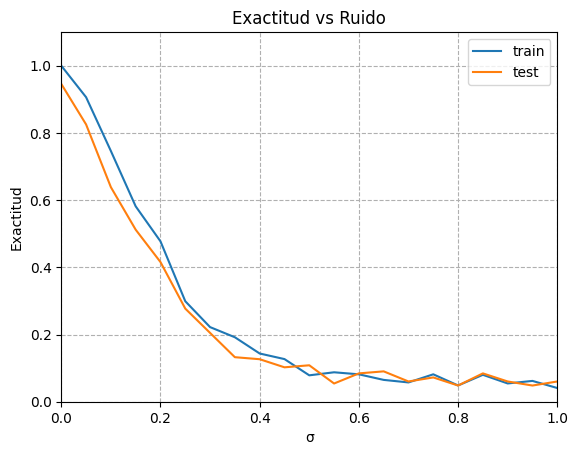

In [203]:
def gaussnoise(original, desvesta):
    img_noise0=copy(original)
    img_noise0=np.reshape(img_noise0,(len(original)**2))

    for i in np.arange(len(img_noise0)):
        noise=random.gauss(0, desvesta)*255
        newval=img_noise0[i]+noise
        img_noise0[i]=newval
    img_noise0=np.reshape(img_noise0,(28,28))
    return img_noise0



vec=np.arange(21)*0.05
vec=np.around(vec,decimals=2)
noise_acc_train=[]
noise_acc_test=[]



for i in vec:
    noise_X=np.zeros((28,28))
    noise_X=np.expand_dims(noise_X, axis=0)
    noise_X=np.expand_dims(noise_X, axis=3)
    desvesta=i
    for i in np.arange(len(test_x2)):
        img_noise=gaussnoise(test_x2[i],desvesta)
        img_noise =np.expand_dims(img_noise, axis=0)
        img_noise =np.expand_dims(img_noise, axis=3)
        noise_X = np.append(noise_X,img_noise, axis=0)
    noise_X=noise_X[1:len(noise_X)]
    history_noise=model_fin.evaluate(noise_X, test_y2OHE, verbose=0)
    noise_acc_test=np.append(noise_acc_test, history_noise[1])

for i in vec:
    noise_X=np.zeros((28,28))
    noise_X=np.expand_dims(noise_X, axis=0)
    noise_X=np.expand_dims(noise_X, axis=3)
    desvesta=i
    for i in np.arange(len(train_x2)):
        img_noise=gaussnoise(train_x2[i],desvesta)
        img_noise =np.expand_dims(img_noise, axis=0)
        img_noise =np.expand_dims(img_noise, axis=3)
        noise_X = np.append(noise_X,img_noise, axis=0)
    noise_X=noise_X[1:len(noise_X)]
    history_noise=model_fin.evaluate(noise_X, train_y2OHE, verbose=0)
    noise_acc_train=np.append(noise_acc_train, history_noise[1])



plt.plot(vec,noise_acc_train)
plt.plot(vec,noise_acc_test)
plt.title('Exactitud vs Ruido')
plt.ylabel('Exactitud')
plt.xlabel('σ')
plt.grid(True, linestyle='--',)
plt.ylim([0,1.1])
plt.xlim([0,1])
plt.legend(['train', 'test'], loc='upper right')